# Compartments & Saddleplots

Welcome to the compartments and saddleplot notebook! 

This notebook illustrates cooltools functions used for investigating chromosomal compartments, visible as plaid patterns in mammalian interphase contact frequency maps.

These plaid patterns reflect tendencies of chromosome regions to make more frequent contacts with regions of the same type: active regions have increased contact frequency with other active regions, and intactive regions tend to contact other inactive regions more frequently. The strength of compartmentalization has been show to vary through the cell cycle, across cell types, and after degredation of components of the cohesin complex. 

In this notebook we:

* obtain compartment profiles using eigendecomposition
* calculate and visualize strength of compartmentalization using saddleplots

In [1]:

# set the number of threads for many common libraries
from os import environ
N_THREADS = '1'
environ['OMP_NUM_THREADS'] = N_THREADS
environ['OPENBLAS_NUM_THREADS'] = N_THREADS
environ['MKL_NUM_THREADS'] = N_THREADS
environ['VECLIB_MAXIMUM_THREADS'] = N_THREADS
environ['NUMEXPR_NUM_THREADS'] = N_THREADS
# https://superfastpython.com/numpy-number-blas-threads/

In [2]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess
import seaborn as sns
import multiprocess as mp

In [3]:
# Import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting

In [4]:
%load_ext autoreload
%autoreload 2
# from saddle import saddleplot

In [5]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
import cooltools
import bioframe
from matplotlib.colors import LogNorm
from helper_func import saddleplot
from data_catalog import bws, bws_vlim, telo_dict
from helper_func import get_stack, show_stacks

In [6]:
from tqdm import tqdm
from tqdm.notebook import trange, tqdm
import warnings
from mpire import WorkerPool

In [7]:
telo_dict

{'mMito': '/abyss/sergpolly/data_ranger/finalcoolers/ranGAP1-0-Ms-R1R2.hg38.mapq_30.1000.mcool',
 'mTelo': '/abyss/sergpolly/data_ranger/finalcoolers/ranGAP1-0-Telo-R2.hg38.mapq_30.1000.mcool',
 'mCyto': '/abyss/sergpolly/data_ranger/finalcoolers/ranGAP1-0-Cyto-R1.hg38.mapq_30.1000.mcool',
 'm5hR1R2': '/abyss/sergpolly/data_ranger/finalcoolers/ranGAP1-0-G1s-R1R2.hg38.mapq_30.1000.mcool',
 'm10hR1R2': '/abyss/sergpolly/data_ranger/finalcoolers/ranGAP1-0-10hR-R1R3.hg38.mapq_30.1000.mcool',
 'pMito': '/abyss/sergpolly/data_ranger/finalcoolers/ranGAP1-2-Ms-R1R2.hg38.mapq_30.1000.mcool',
 'pTelo': '/abyss/sergpolly/data_ranger/finalcoolers/ranGAP1-4-Telo-R2.hg38.mapq_30.1000.mcool',
 'pCyto': '/abyss/sergpolly/data_ranger/finalcoolers/ranGAP1-4-Cyto-R1.hg38.mapq_30.1000.mcool',
 'p5hR1R2': '/abyss/sergpolly/data_ranger/finalcoolers/ranGAP1-7-G1s-R1R2.hg38.mapq_30.1000.mcool',
 'p10hR1R2': '/abyss/sergpolly/data_ranger/finalcoolers/ranGAP1-12-10hR-R1R3.hg38.mapq_30.1000.mcool',
 'mp10hR1R2':

## Calculating per-chromosome compartmentalization

We first load the Hi-C data at 100 kbp resolution. 

Note that the current implementation of eigendecomposition in cooltools assumes that individual regions can be held in memory-- for hg38 at 100kb this is either a 2422x2422 matrix for chr2, or a 3255x3255 matrix for the full cooler here.

In [8]:
# define genomic view that will be used to call dots and pre-compute expected
# ...
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms_full = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
# # remove "bad" chromosomes and near-empty arms ...
included_arms = hg38_arms_full["name"].to_list()[:44] # all autosomal ones ...
hg38_arms = hg38_arms_full[hg38_arms_full["name"].isin(included_arms)].reset_index(drop=True)

In [9]:
## fasta sequence is required for calculating binned profile of GC conent
if not os.path.isfile('./hg38.fa'):
    ## note downloading a ~1Gb file can take a minute
    subprocess.call('wget https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/hg38.fa.gz', shell=True)
    subprocess.call('gunzip hg38.fa.gz', shell=True)
# ...
# gc_fname = f'hg38_gc_cov_{binsize//1000}kb.tsv'
# if os.path.isfile(gc_fname):
#     print(f"loading exiasting fiole {gc_fname} ...")
#     gc_cov = pd.read_csv(gc_fname, sep='\t')
# else:
#     hg38_genome = bioframe.load_fasta('./hg38.fa');
#     ## note the next command may require installing pysam
#     gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
#     gc_cov.to_csv(gc_fname, index=False, sep='\t')
# display(gc_cov.head())

In [10]:
# load some genes ...
cols = [
    "chrom",
    "start",
    "end",
    "strand",
    "GeneName",
    "FPKM",
]
gene_columns={
    "Gene ID" : "GeneID",
    "Gene Name" : "GeneName",
    "Reference" : "chrom",
    "Strand" : "strand",
    "Start" : "start",
    "End" : "end",
    "Coverage" : "coverage",
    "FPKM" : "FPKM",
    "TPM" : "TPM",
}

all_gene_df = pd.read_csv(
    "./fini_genes/hg38.refGene.exons.reducedchroms.hgbed",
    sep="\t",
    usecols=[0,1,2,3,4,5,8,12,13],
    names=["chrom","start","end","GeneName","score","strand","type","exonStarts","exonEnds"]
)

In [11]:
# cooler files that we'll work on :
telo_cis_eigs_gene = {}
for binsize in [10_000, 25_000, 50_000, 100_000, 250_000]:
    print(f"working {binsize=} ...")
    telo_clrs = { _k: cooler.Cooler(f"{_path}::/resolutions/{binsize}") for _k, _path in telo_dict.items() }
    clr_ctrl = telo_clrs["m5hR1R2"]
    bins = clr_ctrl.bins()[:]
    gene_cov = bioframe.frac_gene_coverage(
        bins,
        all_gene_df,
    )[["chrom","start","end","count"]]
    # orient eigenvectors by genecov ...
    # tried doing nested multiprocess inside each WorkerPool - it fails ...
    # check back later ...
    def _job(packed_data, sample):
        clr_dict, ref_track, view_df = packed_data
        from multiprocess import Pool
        from cooltools import eigs_cis
        nproc = 8
        pool = Pool(nproc)
        map_ = pool.imap
        _clr = clr_dict[sample]
        evals, eigs = eigs_cis(
                            clr_dict[sample],
                            ref_track,
                            view_df=view_df,
                            n_eigs=20,
                            map = map_,
                        )
        # close that pool !
        pool.close()
        return (sample, evals, eigs)
    # _job is multiprocessing-based here - so - no daemons ! ...
    with WorkerPool(
        n_jobs=8,
        daemon=False,
        shared_objects=( telo_clrs, gene_cov, hg38_arms, ),
        start_method="forkserver",  # little faster than spawn, fork is the fastest
        use_dill=True
    ) as wpool:
        results = wpool.map(_job, telo_clrs, progress_bar=True)
    # sort out the results - repackage them ...
    telo_cis_eigs_gene[binsize] = {sample: (evals, eigs) for sample, evals, eigs in results}

working binsize=10000 ...


  0%|                                                                                                                            | 0/16 [05:01<?, ?it/s]/data/sergpolly/cooltools/cooltools/lib/numutils.py:475: UserWarning: Number n of requested eigenvalues is larger than the matrix size.
  warnings.warn(
  0%|                                                                                                                            | 0/16 [05:03<?, ?it/s]/data/sergpolly/cooltools/cooltools/lib/numutils.py:475: UserWarning: Number n of requested eigenvalues is larger than the matrix size.
  warnings.warn(
  0%|                                                                                                                            | 0/16 [05:06<?, ?it/s]/data/sergpolly/cooltools/cooltools/lib/numutils.py:475: UserWarning: Number n of requested eigenvalues is larger than the matrix size.
  warnings.warn(
  0%|                                                                                

working binsize=25000 ...


  0%|                                                                                                                            | 0/16 [00:44<?, ?it/s]/data/sergpolly/cooltools/cooltools/lib/numutils.py:475: UserWarning: Number n of requested eigenvalues is larger than the matrix size.
  warnings.warn(
 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                     | 13/16 [01:29<00:10,  3.60s/it]/data/sergpolly/cooltools/cooltools/lib/numutils.py:475: UserWarning: Number n of requested eigenvalues is larger than the matrix size.
  warnings.warn(
/data/sergpolly/cooltools/cooltools/lib/numutils.py:475: UserWarning: Number n of requested eigenvalues is larger than the matrix size.
  warnings.warn(
/data/sergpolly/cooltools/cooltools/api/eigdecomp.py:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = scipy.stats.spearmanr(phasing_track[mask], eigvec[mask])[0]
/data/sergpolly/c

working binsize=50000 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:33<00:00,  1.27it/s]


working binsize=100000 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.92it/s]


working binsize=250000 ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  2.40it/s]


# draw EV1s for different samples to check if resolutions worked ...

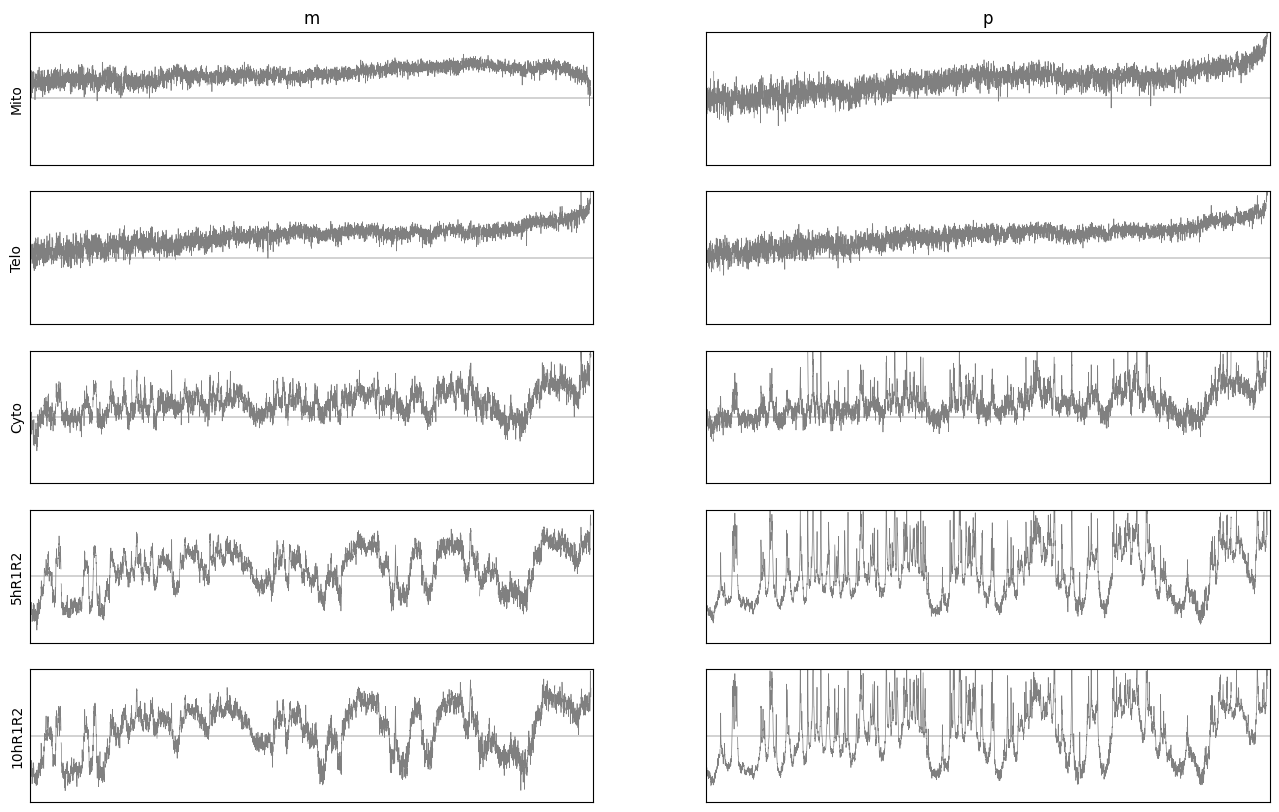

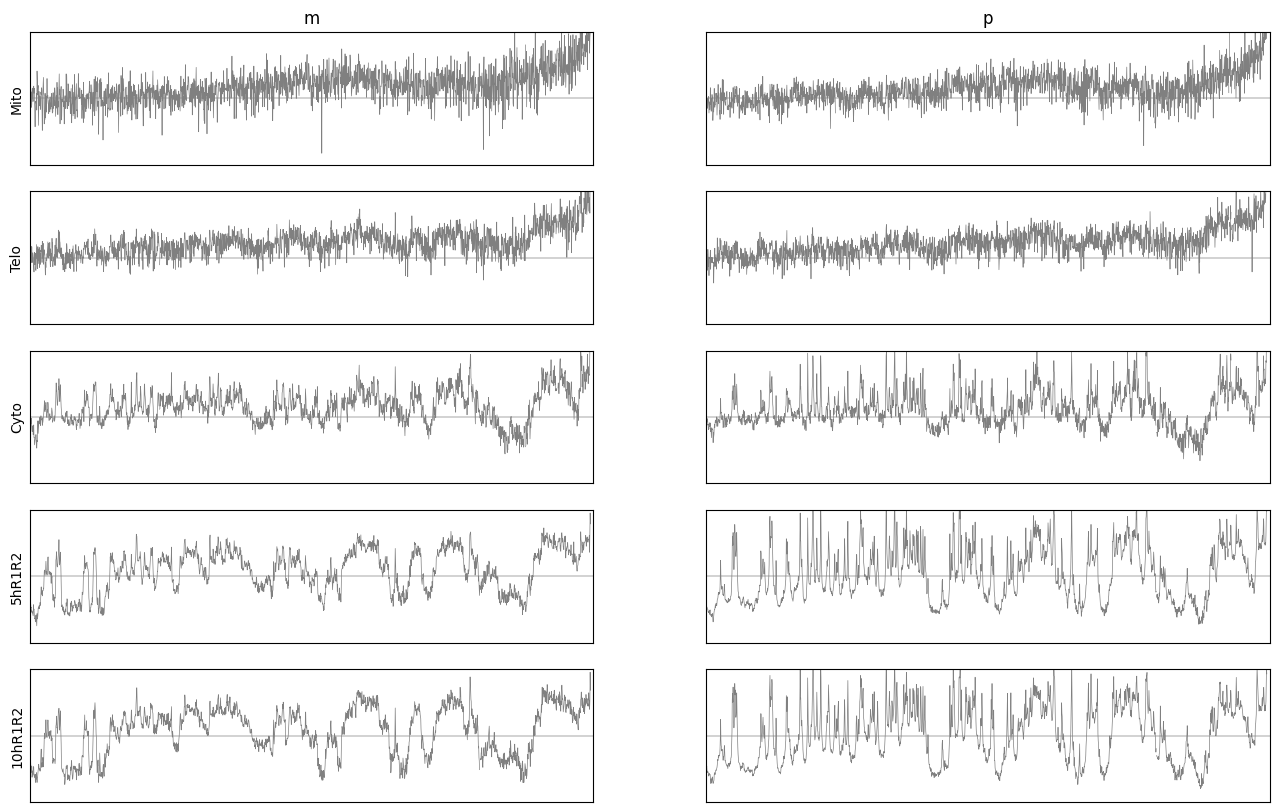

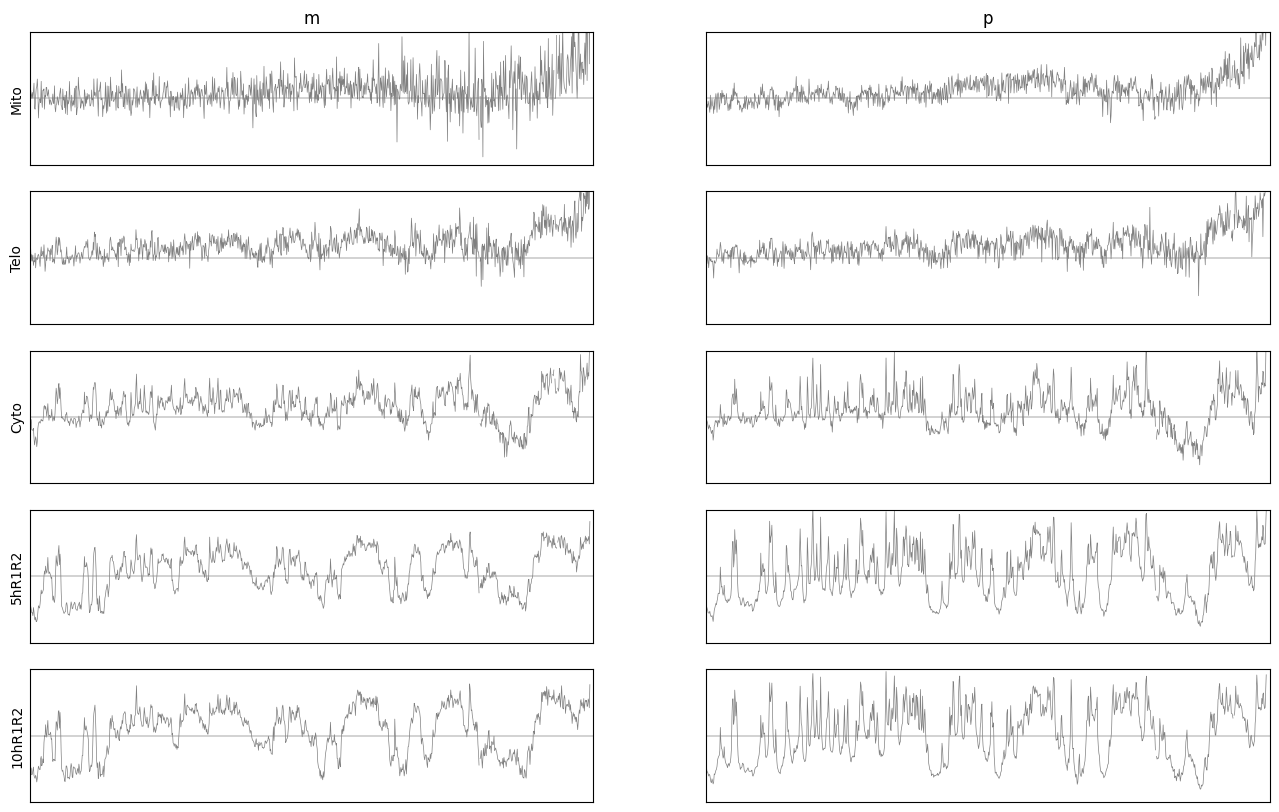

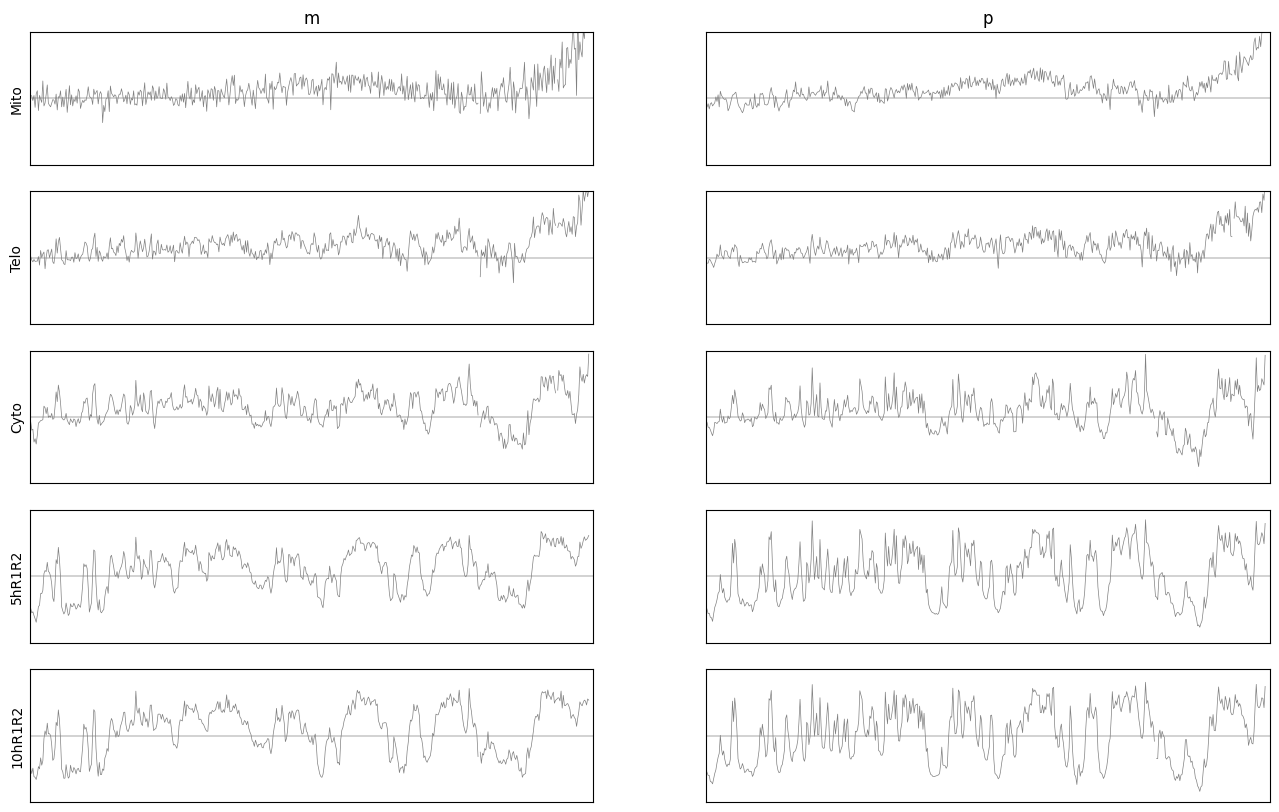

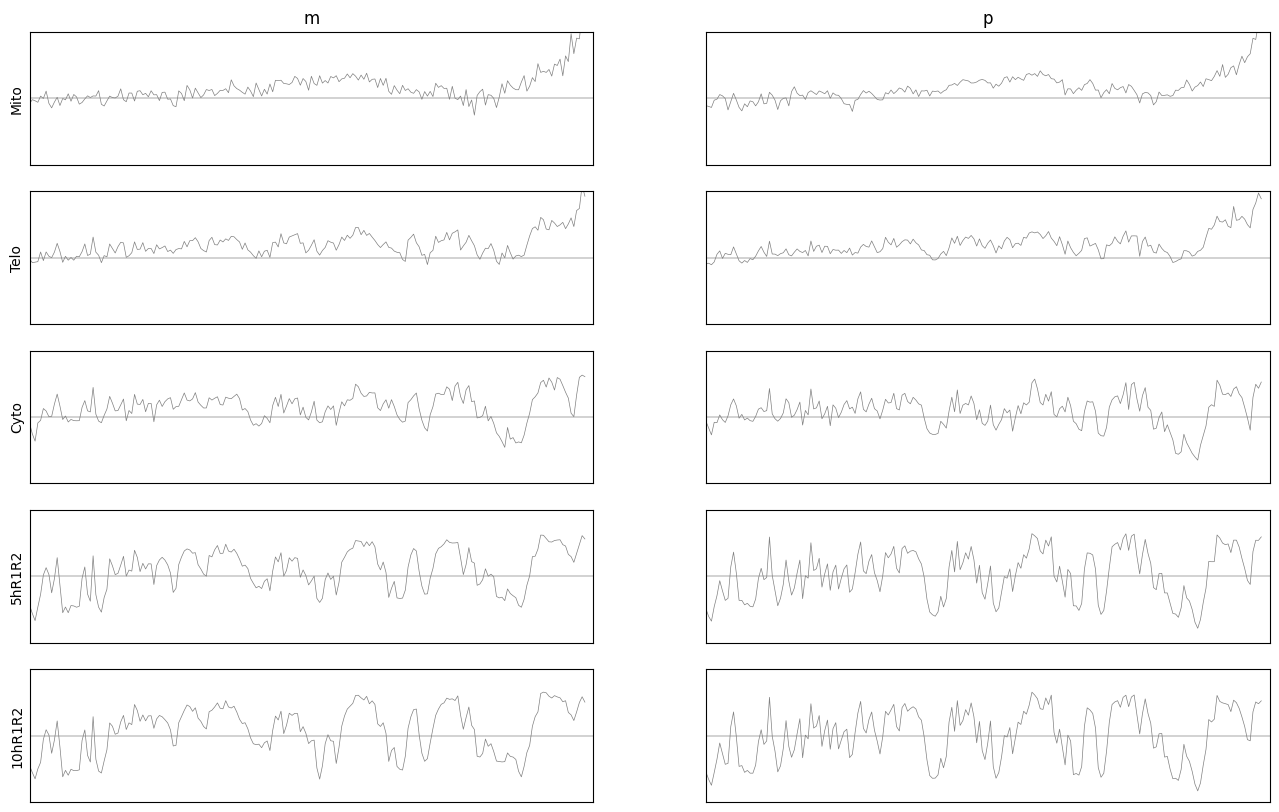

In [19]:
sub_samples_m = [
    "mMito",
    "mTelo",
    "mCyto",
    "m5hR1R2",
    "m10hR1R2",
]
sub_samples_p = [
    "pMito",
    "pTelo",
    "pCyto",
    "p5hR1R2",
    "p10hR1R2",
]


# a contiguous region ...
the_region = hg38_arms.set_index("name").loc["chr12_p"]
#
_start = 120_000_000
_width = 55_000_000
the_region = ("chr6",_start,_start+_width)


for binsize in [10_000, 25_000, 50_000, 100_000, 250_000]:
    fig, axs = plt.subplots(
        nrows=len(sub_samples_m),
        ncols=2,
        figsize=(16,10),
        sharex=True,
        sharey=True,
    )
    for sample_m, sample_p, (i, axs) in zip(sub_samples_m, sub_samples_p, enumerate(axs)):
        axm,axp = axs
        meval, meigs = telo_cis_eigs_gene[binsize][sample_m]
        peval, peigs = telo_cis_eigs_gene[binsize][sample_p]
        # select for a region
        meigs = bioframe.select(meigs, the_region)
        peigs = bioframe.select(peigs, the_region)
        axm.plot([0,len(meigs)],[0,0],'k',lw=0.25)
        axm.plot( np.arange(0, len(meigs)), meigs['E1'], label='E1',linewidth=0.5, color="gray")
        # ...
        axp.plot([0,len(peigs)],[0,0],'k',lw=0.25)
        axp.plot( np.arange(0, len(peigs)), peigs['E1'], label='E1',linewidth=0.5, color="gray")
        # ...
        axm.set_xlim(0, len(meigs))
        axp.set_xlim(0, len(peigs))
        # ...
        axm.set_ylim(-1.5, 1.5)
        axp.set_ylim(-1.5, 1.5)
        # ...
        axm.set_xticks([])
        axm.set_yticks([])
        axp.set_xticks([])
        axp.set_yticks([])
        if i == 0:
            axm.set_title("m")
            axp.set_title("p")
        axm.set_ylabel(sample_m.lstrip("m"))

### before saving files check if they exist ...

In [55]:
! ls ev_bedraph
# ! rm ev_bedraph/*.bw

m10hR1R2.100kb.bed  mp10hR1R2.100kb.bed  N93mp10.100kb.bed   p5hR1R2.100kb.bed
m10hR1R2.10kb.bed   mp10hR1R2.10kb.bed	 N93mp10.10kb.bed    p5hR1R2.10kb.bed
m10hR1R2.250kb.bed  mp10hR1R2.250kb.bed  N93mp10.250kb.bed   p5hR1R2.250kb.bed
m10hR1R2.25kb.bed   mp10hR1R2.25kb.bed	 N93mp10.25kb.bed    p5hR1R2.25kb.bed
m10hR1R2.50kb.bed   mp10hR1R2.50kb.bed	 N93mp10.50kb.bed    p5hR1R2.50kb.bed
m5hR1R2.100kb.bed   mTelo.100kb.bed	 N93p10.100kb.bed    pCyto.100kb.bed
m5hR1R2.10kb.bed    mTelo.10kb.bed	 N93p10.10kb.bed     pCyto.10kb.bed
m5hR1R2.250kb.bed   mTelo.250kb.bed	 N93p10.250kb.bed    pCyto.250kb.bed
m5hR1R2.25kb.bed    mTelo.25kb.bed	 N93p10.25kb.bed     pCyto.25kb.bed
m5hR1R2.50kb.bed    mTelo.50kb.bed	 N93p10.50kb.bed     pCyto.50kb.bed
mCyto.100kb.bed     N93m10.100kb.bed	 N93p5.100kb.bed     pMito.100kb.bed
mCyto.10kb.bed	    N93m10.10kb.bed	 N93p5.10kb.bed      pMito.10kb.bed
mCyto.250kb.bed     N93m10.250kb.bed	 N93p5.250kb.bed     pMito.250kb.bed
mCyto.25kb.bed	    N93m10.25kb.be

In [53]:
! ls ev_bigwig

m10hR1R2.100kb.bw  mp10hR1R2.100kb.bw  N93mp10.100kb.bw   p5hR1R2.100kb.bw
m10hR1R2.10kb.bw   mp10hR1R2.10kb.bw   N93mp10.10kb.bw	  p5hR1R2.10kb.bw
m10hR1R2.250kb.bw  mp10hR1R2.250kb.bw  N93mp10.250kb.bw   p5hR1R2.250kb.bw
m10hR1R2.25kb.bw   mp10hR1R2.25kb.bw   N93mp10.25kb.bw	  p5hR1R2.25kb.bw
m10hR1R2.50kb.bw   mp10hR1R2.50kb.bw   N93mp10.50kb.bw	  p5hR1R2.50kb.bw
m5hR1R2.100kb.bw   mTelo.100kb.bw      N93p10.100kb.bw	  pCyto.100kb.bw
m5hR1R2.10kb.bw    mTelo.10kb.bw       N93p10.10kb.bw	  pCyto.10kb.bw
m5hR1R2.250kb.bw   mTelo.250kb.bw      N93p10.250kb.bw	  pCyto.250kb.bw
m5hR1R2.25kb.bw    mTelo.25kb.bw       N93p10.25kb.bw	  pCyto.25kb.bw
m5hR1R2.50kb.bw    mTelo.50kb.bw       N93p10.50kb.bw	  pCyto.50kb.bw
mCyto.100kb.bw	   N93m10.100kb.bw     N93p5.100kb.bw	  pMito.100kb.bw
mCyto.10kb.bw	   N93m10.10kb.bw      N93p5.10kb.bw	  pMito.10kb.bw
mCyto.250kb.bw	   N93m10.250kb.bw     N93p5.250kb.bw	  pMito.250kb.bw
mCyto.25kb.bw	   N93m10.25kb.bw      N93p5.25kb.bw	  pMito.25kb.bw
mCy

# Write bedGraph-like files for further exploration ...

In [54]:
_cols = ["chrom", "start", "end", "E1"]
for binsize in [10_000, 25_000, 50_000, 100_000, 250_000]:
    # Write the insulation track as a bigwig:
    for k, _fname in telo_dict.items():
        # derive output name
        out_fname = f"{k}.{binsize//1_000}kb.bed"
        telo_cis_eigs_gene[binsize][k][1][_cols].to_csv(
            #
            f"ev_bedraph/{out_fname}",
            sep="\t",
            index=False,
        )
        print(f"generated {out_fname} ...")


generated mMito.10kb.bed ...
generated mTelo.10kb.bed ...
generated mCyto.10kb.bed ...
generated m5hR1R2.10kb.bed ...
generated m10hR1R2.10kb.bed ...
generated pMito.10kb.bed ...
generated pTelo.10kb.bed ...
generated pCyto.10kb.bed ...
generated p5hR1R2.10kb.bed ...
generated p10hR1R2.10kb.bed ...
generated mp10hR1R2.10kb.bed ...
generated N93m5.10kb.bed ...
generated N93m10.10kb.bed ...
generated N93p5.10kb.bed ...
generated N93p10.10kb.bed ...
generated N93mp10.10kb.bed ...
generated mMito.25kb.bed ...
generated mTelo.25kb.bed ...
generated mCyto.25kb.bed ...
generated m5hR1R2.25kb.bed ...
generated m10hR1R2.25kb.bed ...
generated pMito.25kb.bed ...
generated pTelo.25kb.bed ...
generated pCyto.25kb.bed ...
generated p5hR1R2.25kb.bed ...
generated p10hR1R2.25kb.bed ...
generated mp10hR1R2.25kb.bed ...
generated N93m5.25kb.bed ...
generated N93m10.25kb.bed ...
generated N93p5.25kb.bed ...
generated N93p10.25kb.bed ...
generated N93mp10.25kb.bed ...
generated mMito.50kb.bed ...
generat

## Write bigwigs with EV1 for visual exploration ...

In [48]:
for binsize in [10_000, 25_000, 50_000, 100_000, 250_000]:
    # Write the insulation track as a bigwig:
    for k, _fname in telo_dict.items():
        # # derive output name
        out_fname = f"{k}.{binsize//1_000}kb.bw"
        df = telo_cis_eigs_gene[binsize][k][1]
        print(f"generating {out_fname} ...")
        # let's save only 50_000 bp window derived insulation ...
        # store in bigwig ...
        bioframe.to_bigwig(
            df,
            hg38_chromsizes,
            f"ev_bigwig/{out_fname}",
            value_field="E1",
            path_to_binary="./bedGraphToBigWig"
        )


generating mMito.10kb.bw ...
generating mTelo.10kb.bw ...
generating mCyto.10kb.bw ...
generating m5hR1R2.10kb.bw ...
generating m10hR1R2.10kb.bw ...
generating pMito.10kb.bw ...
generating pTelo.10kb.bw ...
generating pCyto.10kb.bw ...
generating p5hR1R2.10kb.bw ...
generating p10hR1R2.10kb.bw ...
generating mp10hR1R2.10kb.bw ...
generating N93m5.10kb.bw ...
generating N93m10.10kb.bw ...
generating N93p5.10kb.bw ...
generating N93p10.10kb.bw ...
generating N93mp10.10kb.bw ...
generating mMito.25kb.bw ...
generating mTelo.25kb.bw ...
generating mCyto.25kb.bw ...
generating m5hR1R2.25kb.bw ...
generating m10hR1R2.25kb.bw ...
generating pMito.25kb.bw ...
generating pTelo.25kb.bw ...
generating pCyto.25kb.bw ...
generating p5hR1R2.25kb.bw ...
generating p10hR1R2.25kb.bw ...
generating mp10hR1R2.25kb.bw ...
generating N93m5.25kb.bw ...
generating N93m10.25kb.bw ...
generating N93p5.25kb.bw ...
generating N93p10.25kb.bw ...
generating N93mp10.25kb.bw ...
generating mMito.50kb.bw ...
generat

# OLD STUFF - shouldb't be in the generation noterbook ...

In [16]:
import datashader as ds, xarray as xr
from datashader import transfer_functions as tf, reductions as rd
from datashader.mpl_ext import dsshow, alpha_colormap
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
import itertools

In [17]:
df = pd.DataFrame({
    "GC" : gc_cov["GC"],
    "count" : gene_cov["count"].astype("float"),
})

/tmp/ipykernel_1626603/1999069239.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  [df.groupby(_cats).get_group(i)["GC"] for i in gene_counts],


Text(0, 0.5, 'gene count')

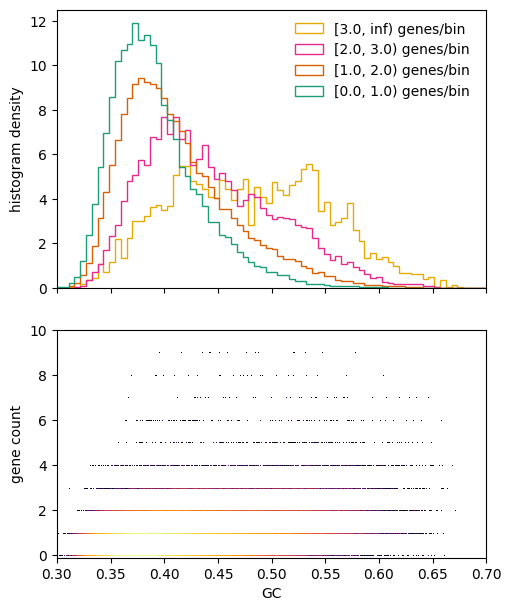

In [18]:
_cats = pd.cut(df["count"],bins=[0,1,2,3,np.inf],right=False)
cmap = mpl.colormaps['Dark2']
gene_counts = _cats.dtypes.categories

f,axs = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(5,6))
f.set_constrained_layout(True)

GC_range=(0.3,0.7)

axs[0].hist(
    [df.groupby(_cats).get_group(i)["GC"] for i in gene_counts],
    density=True,
    histtype="step",
    bins=np.linspace(*GC_range,75),
    label=[f"{i} genes/bin " for i in gene_counts],
    # cumulative=True,
    # log=True,
    # stacked=True,
    color=cmap(np.linspace(0, 0.7, len(gene_counts)))
);
axs[0].legend(frameon=False)
axs[0].set_ylabel("histogram density")

dsshow(
    df,
    ds.Point("GC","count"),
    norm='eq_hist',
    cmap="inferno",
    aspect=0.021,
    x_range=GC_range,
    y_range=(-0.1,10),
    ax=axs[1],
)
axs[1].set_xlabel("GC")
axs[1].set_ylabel("gene count")

Cooltools also allows a view to be passed for eigendecomposition to limit to a certain set of regions. The following code creates the simplest view, of the two chromosomes in this cooler.|

To capture the pattern of compartmentalization within-chromosomes, in cis, cooltools `eigs_cis` first removes
the dependence of contact frequency by distance, and then performs eigenedecompostion. 

In [19]:
# orient eigenvectors by GC - let's skip it for now - just do the genecov ...

# # tried doing nested multiprocess inside each WorkerPool - it fails ...
# # check back later ...
# def _job(packed_data, sample):
#     clr_dict, ref_track, view_df = packed_data
#     from multiprocess import Pool
#     from cooltools import eigs_cis
#     nproc = 8
#     pool = Pool(nproc)
#     map_ = pool.imap
#     _clr = clr_dict[sample]
#     evals, eigs = eigs_cis(
#                         clr_dict[sample],
#                         ref_track,
#                         view_df=view_df,
#                         n_eigs=20,
#                         map = map_,
#                     )
#     # close that pool !
#     pool.close()
#     return (sample, evals, eigs)

# # _job is multiprocessing-based here - so - no daemons ! ...
# with WorkerPool(
#     n_jobs=8,
#     daemon=False,
#     shared_objects=( telo_clrs, gc_cov, hg38_arms, ),
#     start_method="forkserver",  # little faster than spawn, fork is the fastest
#     use_dill=True
# ) as wpool:
#     results = wpool.map(_job, telo_clrs, progress_bar=True)

# # sort out the results - repackage them ...
# telo_cis_eigs_GC = {sample: (evals, eigs) for sample, evals, eigs in results}

In [21]:
# orient eigenvectors by genecov ...

# tried doing nested multiprocess inside each WorkerPool - it fails ...
# check back later ...
def _job(packed_data, sample):
    clr_dict, ref_track, view_df = packed_data
    from multiprocess import Pool
    from cooltools import eigs_cis
    nproc = 8
    pool = Pool(nproc)
    map_ = pool.imap
    _clr = clr_dict[sample]
    evals, eigs = eigs_cis(
                        clr_dict[sample],
                        ref_track,
                        view_df=view_df,
                        n_eigs=20,
                        map = map_,
                    )
    # close that pool !
    pool.close()
    return (sample, evals, eigs)

# _job is multiprocessing-based here - so - no daemons ! ...
with WorkerPool(
    n_jobs=8,
    daemon=False,
    shared_objects=( telo_clrs, gene_cov, hg38_arms, ),
    start_method="forkserver",  # little faster than spawn, fork is the fastest
    use_dill=True
) as wpool:
    results = wpool.map(_job, telo_clrs, progress_bar=True)

# sort out the results - repackage them ...
telo_cis_eigs_gene = {sample: (evals, eigs) for sample, evals, eigs in results}

  0%|                                                                                                                               | 0/16 [00:40<?, ?it/s]/data/sergpolly/cooltools/cooltools/lib/numutils.py:475: UserWarning: Number n of requested eigenvalues is larger than the matrix size.
  warnings.warn(
 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 12/16 [01:24<00:16,  4.17s/it]/data/sergpolly/cooltools/cooltools/lib/numutils.py:475: UserWarning: Number n of requested eigenvalues is larger than the matrix size.
  warnings.warn(
/data/sergpolly/cooltools/cooltools/api/eigdecomp.py:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = scipy.stats.spearmanr(phasing_track[mask], eigvec[mask])[0]
/data/sergpolly/cooltools/cooltools/api/eigdecomp.py:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = scip

samples we've got EV1 for ...
```
mMito
mTelo
mCyto
m5hR1R2
m10hR1R2
pMito
pTelo
pCyto
p5hR1R2
p10hR1R2
mp10hR1R2
N93m5
N93m10
N93p5
N93p10
N93mp10
```

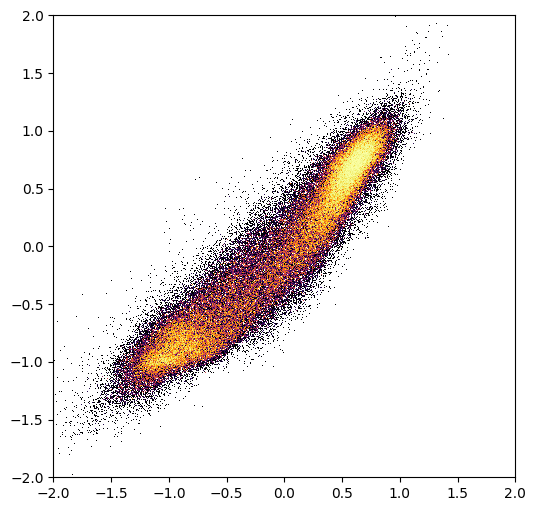

In [22]:
# compare some EV1 ...

samplex = "N93m5"
sampley = "N93p5"
_, xeigs = telo_cis_eigs_gene[samplex]
_, yeigs = telo_cis_eigs_gene[sampley]

f,ax = plt.subplots(nrows=1,ncols=1, figsize=(6,6),sharex=True,sharey=True)
_art = dsshow(
    pd.DataFrame({"x":xeigs["E1"],"y":yeigs["E1"]}),
    ds.Point("x", "y"),
    # ds.count_cat("cat"),
    norm='eq_hist',
    cmap="inferno",
    x_range=(-2,2),
    y_range=(-2,2),
    ax=ax,
)


### saving EV1 as bigWigs ...

 - rewrite using bigtools ...

In [23]:
# for k, (eval, evdf) in telo_cis_eigs.items():
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", category=RuntimeWarning)
#         #
#         print(f"saving {k}-ev called at {binsize//1000}kb to bigwig ...")
#         bioframe.to_bigwig(
#             evdf,
#             hg38_chromsizes,
#             f"ev_bigwig/{k}.{binsize//1000}kb.bw",
#             value_field="E1",
#             path_to_binary="/sharehome/sergpolly/bin/bedGraphToBigWig",
#         )

In [124]:
from sklearn import decomposition
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

In [282]:
chr="chr18"

_common_mask = pd.concat(
    [_df.query(f"chrom=='{chr}'")["E1"].rename(_sample) for _sample, (_, _df) in telo_cis_eigs_gene.items()],
    axis=1,
).isna().any(axis=1).to_numpy()

_pca_samples = [
    # 'mTelo',
    # 'mCyto',
    'm5hR1R2',
    # 'm10hR1R2',
    # 'pTelo',
    # 'pCyto',
    'p5hR1R2',
    # 'p10hR1R2',
    # 'mp10hR1R2',
    'N93m5',
    # 'N93m10',
    # 'N93p5',
    'N93p10',
    # 'N93mp10',
]
_rest_samples = [_sample for _sample in telo_cis_eigs_gene if (_sample not in _pca_samples)]


X = pd.concat(
    [telo_cis_eigs_gene[_sample][1].query(f"chrom=='{chr}'")["E1"].rename(_sample) for _sample in _pca_samples],
    axis=1,
).to_numpy()[~_common_mask].T



X_rest = pd.concat(
    [telo_cis_eigs_gene[_sample][1].query(f"chrom=='{chr}'")["E1"].rename(_sample) for _sample in _rest_samples],
    axis=1,
).to_numpy()[~_common_mask].T



pca = decomposition.PCA(n_components=3)
print("running PCA ...")
pca.fit(X)
X_trans = pca.transform(X)
X_rest_trans = pca.transform(X_rest)

print(pca.explained_variance_ratio_)

running PCA ...
[0.5836941  0.36405281 0.05225309]


In [294]:
chr="chr18"

_common_mask = pd.concat(
    [_df["E1"].rename(_sample) for _sample, (_, _df) in telo_cis_eigs_gene.items()],
    axis=1,
).isna().any(axis=1).to_numpy()

_pca_samples = [
    # 'mTelo',
    # 'mCyto',
    'm5hR1R2',
    'm10hR1R2',
    # 'pTelo',
    # 'pCyto',
    'p5hR1R2',
    'p10hR1R2',
    # 'mp10hR1R2',
    'N93m5',
    'N93m10',
    'N93p5',
    'N93p10',
    # 'N93mp10',
]
_rest_samples = [_sample for _sample in telo_cis_eigs_gene if (_sample not in _pca_samples)]


X = pd.concat(
    [telo_cis_eigs_gene[_sample][1]["E1"].rename(_sample) for _sample in _pca_samples],
    axis=1,
).to_numpy()[~_common_mask].T



X_rest = pd.concat(
    [telo_cis_eigs_gene[_sample][1]["E1"].rename(_sample) for _sample in _rest_samples],
    axis=1,
).to_numpy()[~_common_mask].T



pca = decomposition.PCA(n_components=3)
print("running PCA ...")
pca.fit(X)
X_trans = pca.transform(X)
X_rest_trans = pca.transform(X_rest)

print(pca.explained_variance_ratio_)

running PCA ...
[0.60722401 0.25358848 0.06226684]


Text(0, 0.5, 'pc2 0.25')

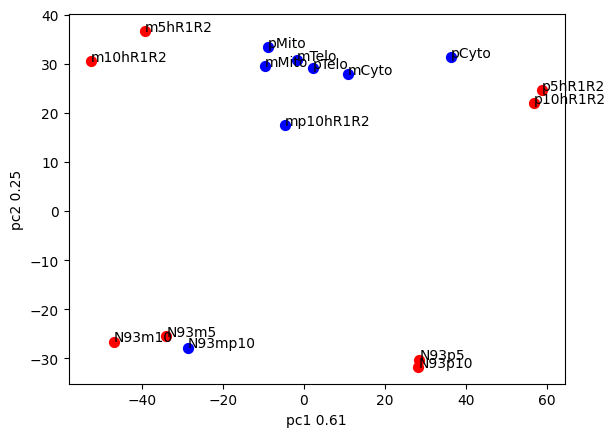

In [295]:

_x, _y, _z = X_trans[:,0], X_trans[:,1], X_trans[:,2]
plt.scatter(_x, _y, s=50, color="red")
ax = plt.gca()
for i, txt in enumerate(_pca_samples):
    ax.annotate(txt, (_x[i], _y[i]))

_x, _y, _z = X_rest_trans[:,0], X_rest_trans[:,1], X_rest_trans[:,2]
plt.scatter(_x, _y, s=50, color="blue")
for i, txt in enumerate(_rest_samples):
    ax.annotate(txt, (_x[i], _y[i]))



_1, _2, _3 = pca.explained_variance_ratio_[:3]
ax.set_xlabel(f"pc1 {_1:.2f}")
ax.set_ylabel(f"pc2 {_2:.2f}")


In [189]:
# _x, _y, _z = X_trans[:,0], X_trans[:,1], X_trans[:,2]
# fig = plt.figure(1, figsize=(6, 6))
# ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
# ax.set_position([0, 0, 0.95, 1])
# _1, _2, _3 = pca.explained_variance_ratio_[:3]
# ax.scatter(_x, _y, _z, edgecolor="k")
# ax.set_xlabel(f"pc1 {_1:.2f}")
# ax.set_ylabel(f"pc2 {_2:.2f}")
# ax.set_zlabel(f"pc3 {_3:.2f}")
# # plt.scatter(_x, _y, s=50, color="red")
# # ax = plt.gca()
# for i, txt in enumerate(_name_samples):
#     ax.text3D(_x[i], _y[i], _z[i], txt)

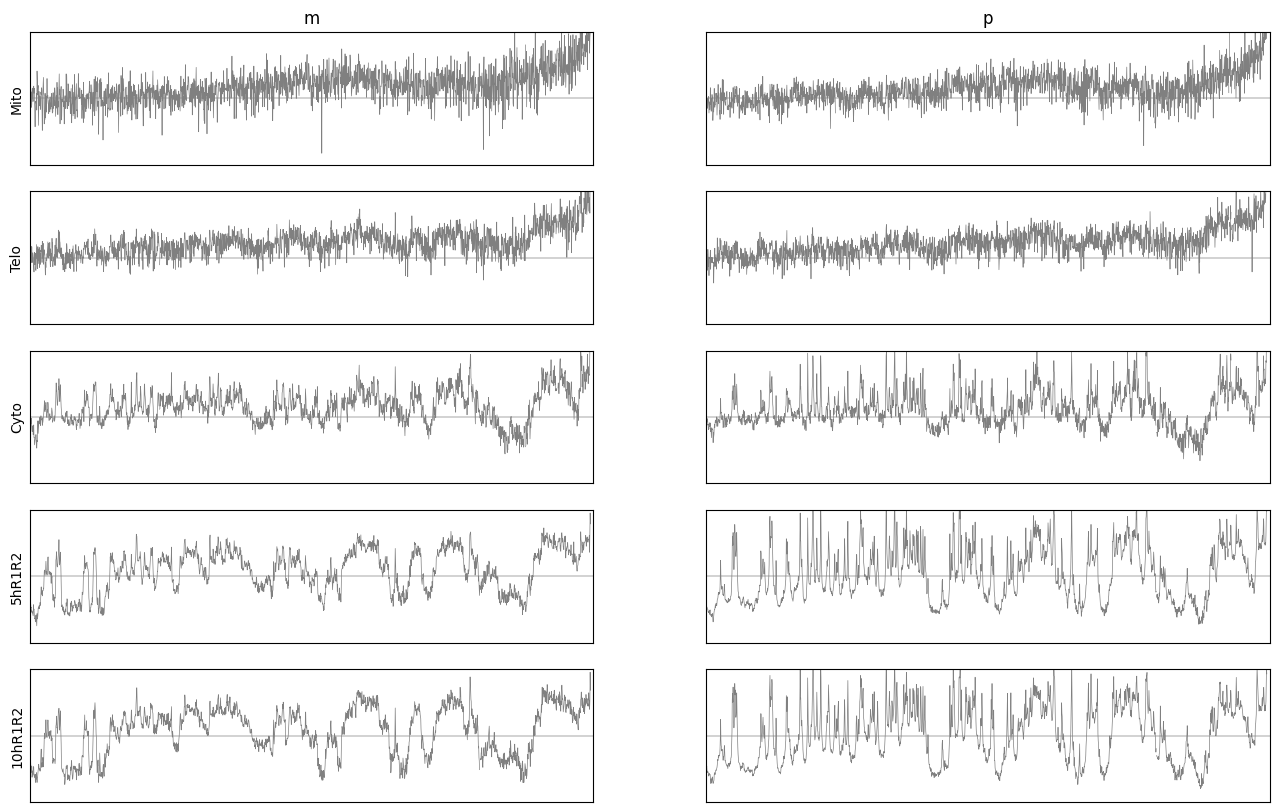

In [25]:
sub_samples_m = [
    "mMito",
    "mTelo",
    "mCyto",
    "m5hR1R2",
    "m10hR1R2",
]
sub_samples_p = [
    "pMito",
    "pTelo",
    "pCyto",
    "p5hR1R2",
    "p10hR1R2",
]

fig, axs = plt.subplots(
    nrows=len(sub_samples_m),
    ncols=2,
    figsize=(16,10),
    sharex=True,
    sharey=True,
)

# a contiguous region ...
the_region = hg38_arms.set_index("name").loc["chr12_p"]
#
_start = 120_000_000
_width = 55_000_000
the_region = ("chr6",_start,_start+_width)

for sample_m, sample_p, (i, axs) in zip(sub_samples_m, sub_samples_p, enumerate(axs)):
    axm,axp = axs
    meval, meigs = telo_cis_eigs_gene[sample_m]
    peval, peigs = telo_cis_eigs_gene[sample_p]
    # select for a region
    meigs = bioframe.select(meigs, the_region)
    peigs = bioframe.select(peigs, the_region)
    axm.plot([0,len(meigs)],[0,0],'k',lw=0.25)
    axm.plot( np.arange(0, len(meigs)), meigs['E1'], label='E1',linewidth=0.5, color="gray")
    # ...
    axp.plot([0,len(peigs)],[0,0],'k',lw=0.25)
    axp.plot( np.arange(0, len(peigs)), peigs['E1'], label='E1',linewidth=0.5, color="gray")
    # ...
    axm.set_xlim(0, len(meigs))
    axp.set_xlim(0, len(peigs))
    # ...
    axm.set_ylim(-1.5, 1.5)
    axp.set_ylim(-1.5, 1.5)
    # ...
    axm.set_xticks([])
    axm.set_yticks([])
    axp.set_xticks([])
    axp.set_yticks([])
    if i == 0:
        axm.set_title("m")
        axp.set_title("p")
    axm.set_ylabel(sample_m.lstrip("m"))

## Pre-load ID anchors to put the on the map here as well ...

In [26]:
id_anchor_fnames = {
    "mega_2X_enrichment": "ID_anchors/mega_2X_enrichment.fourth_mega.max_size.bed",
    "5hr_2X_enrichment_old": "ID_anchors/5hr_2X_enrichment.second_bulk.max_size.bed",
    "5hr_2X_enrichment": "ID_anchors/5hr_2X_enrichment.pixel_derived.bed",
    "5hr_2X_enrichment_nosing": "ID_anchors/5hr_2X_enrichment.pixel_derived.no_singletons.bed",
    "5hr_notinCyto_2X_enrichment_signal": "ID_anchors/p5notin_pCyto_anchors_2X_enrichment.pixel_derived.signal_peaks.bed",
    "5hr_2X_enrichment_signal": "ID_anchors/5hr_2X_enrichment.pixel_derived.signal_peaks.bed",
    "10hr_2X_enrichment_signal": "ID_anchors/10hrs_2X_enrichment.pixel_derived.signal_peaks.bed",
    "N93p5_2X_enrichment_signal": "ID_anchors/N93p5_2X_enrichment.pixel_derived.signal_peaks.bed",
    "pCyto_2X_enrichment_signal": "ID_anchors/pCyto_2X_enrichment.pixel_derived.signal_peaks.bed",
    "mCyto_2X_enrichment_signal": "ID_anchors/mCyto_2X_enrichment.pixel_derived.signal_peaks.bed",
    "mega_3X_enrichment": "ID_anchors/mega_3X_enrichment.fifth_mega3x.max_size.bed",
    "MEGA_2X_enrichment": "ID_anchors/MEGAp5_2X_enrichment.pixel_derived.signal_peaks.bed",
    "MEGA_weaker_2X_enrichment": "ID_anchors/MEGA_plus_weak_anchors_2X_enrichment.pixel_derived.signal_peaks.bed",
    "MEGAN93_2X_enrichment": "ID_anchors/MEGAN93p5_2X_enrichment.pixel_derived.signal_peaks.bed",
    "MEGAminus_2X_enrichment": "ID_anchors/MEGA_minus_ctrl_2X_enrichment.pixel_derived.signal_peaks.bed",
    "cyto_2x_enrichment": "ID_anchors/cyto_2x_enrichment.third_mCyto.max_size.bed",
}

id_anchors_dict = {}
for id_name, fname in id_anchor_fnames.items():
    id_anchors_dict[id_name] = pd.read_csv(fname, sep="\t")
    # ...
    print(f"loaded {len(id_anchors_dict[id_name]):5d} ID anchors {id_name:>20} in BED format ...")


# _anchors5 = id_anchors_dict["MEGA_2X_enrichment"]
_anchors5 = id_anchors_dict["5hr_2X_enrichment_signal"]
_anchorsCyto = id_anchors_dict["pCyto_2X_enrichment_signal"]

loaded  6760 ID anchors   mega_2X_enrichment in BED format ...
loaded  4200 ID anchors 5hr_2X_enrichment_old in BED format ...
loaded  3071 ID anchors    5hr_2X_enrichment in BED format ...
loaded  2118 ID anchors 5hr_2X_enrichment_nosing in BED format ...
loaded  1407 ID anchors 5hr_notinCyto_2X_enrichment_signal in BED format ...
loaded  2105 ID anchors 5hr_2X_enrichment_signal in BED format ...
loaded  1792 ID anchors 10hr_2X_enrichment_signal in BED format ...
loaded   555 ID anchors N93p5_2X_enrichment_signal in BED format ...
loaded   853 ID anchors pCyto_2X_enrichment_signal in BED format ...
loaded   963 ID anchors mCyto_2X_enrichment_signal in BED format ...
loaded  1625 ID anchors   mega_3X_enrichment in BED format ...
loaded  4623 ID anchors   MEGA_2X_enrichment in BED format ...
loaded  2080 ID anchors MEGA_weaker_2X_enrichment in BED format ...
loaded  1307 ID anchors MEGAN93_2X_enrichment in BED format ...
loaded  2778 ID anchors MEGAminus_2X_enrichment in BED format ...


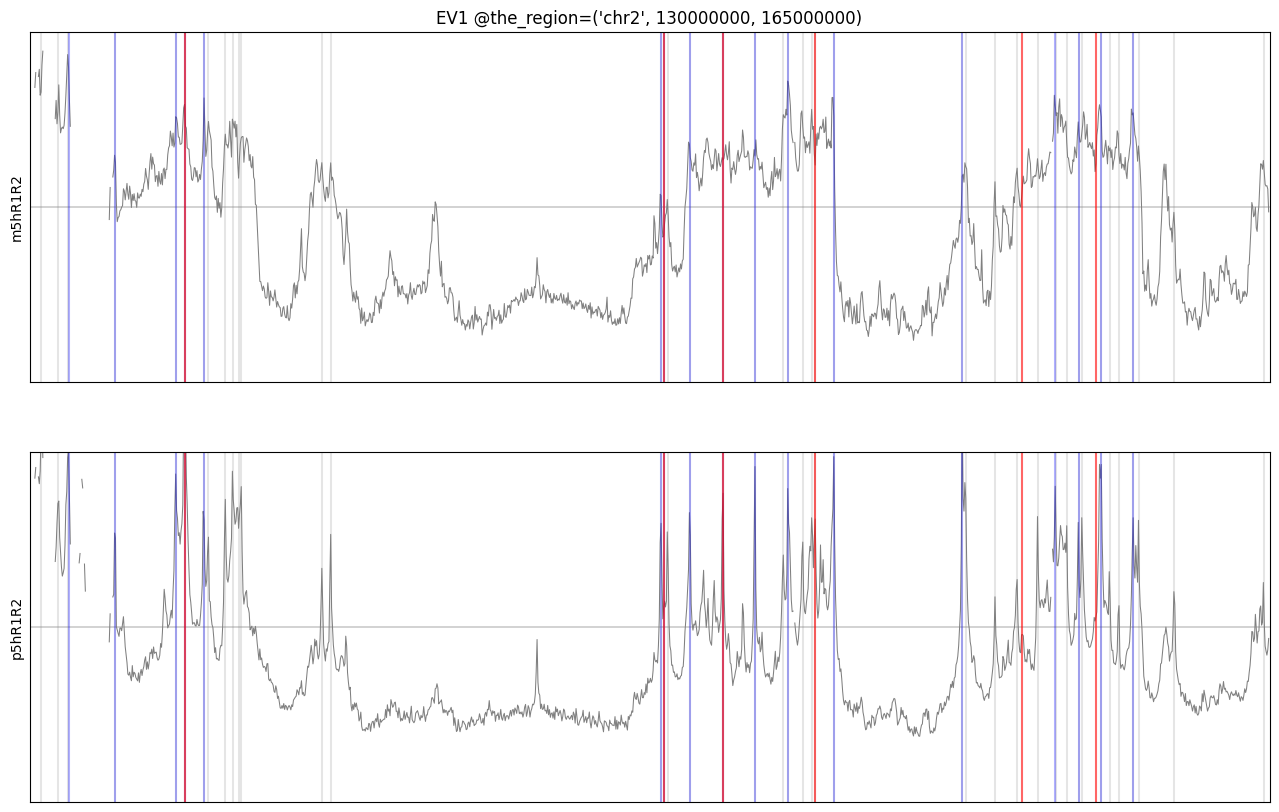

In [297]:
sub_samples =[
    "m5hR1R2",
    # "pCyto",
    "p5hR1R2",
]


fig, axs = plt.subplots(
    nrows=len(sub_samples),
    ncols=1,
    figsize=(16,10),
    sharex=True,
    sharey=True,
)

# a contiguous region ...
the_region = hg38_arms.set_index("name").loc["chr12_p"]
#
_start = 130_000_000
_width = 35_000_000
the_region = ("chr2",_start,_start+_width)


# detect IDs in the region to show on the plots ...
# _anchors5 = id_anchors_dict["5hr_2X_enrichment_signal"]
# _anchorsCyto = id_anchors_dict["pCyto_2X_enrichment_signal"]
# MEGA_2X_enrichment
id_in_reg = bioframe.select(id_anchors_dict["MEGA_2X_enrichment"], the_region)
_id_bins_in_reg_MEGA = id_in_reg.eval("(start - @_start)/@binsize")
id_in_reg = bioframe.select(id_anchors_dict["pCyto_2X_enrichment_signal"], the_region)
_id_bins_in_reg_Cyto = id_in_reg.eval("(start - @_start)/@binsize")
id_in_reg = bioframe.select(id_anchors_dict["5hr_2X_enrichment_signal"], the_region)
_id_bins_in_reg_5hrs = id_in_reg.eval("(start - @_start)/@binsize")

for ii, sample, ax in zip(itertools.count(), sub_samples, axs):
    _eval, _eigs = telo_cis_eigs_gene[sample]
    # select for a region
    _eigs = bioframe.select(_eigs, the_region)
    ax.plot([0,len(_eigs)],[0,0],'k',lw=0.25)
    ax.plot( np.arange(0, len(_eigs)), _eigs['E1'], label='E1',linewidth=0.75, color="gray")
    # ...
    ax.set_xlim(0, len(_eigs))
    # ...
    ax.set_ylim(-1.5, 1.5)
    # ...
    ax.set_xticks([])
    ax.set_yticks([])
    if ii == 0:
        ax.set_title(f"EV1 @{the_region=}")
    ax.set_ylabel(sample)
    for _id_bin in _id_bins_in_reg_MEGA:
        ax.axvline(_id_bin, alpha=0.2, color="grey")
    for _id_bin in _id_bins_in_reg_5hrs:
        ax.axvline(_id_bin, alpha=0.3, color="blue")
    for _id_bin in _id_bins_in_reg_Cyto:
        ax.axvline(_id_bin, alpha=0.6, color="red")


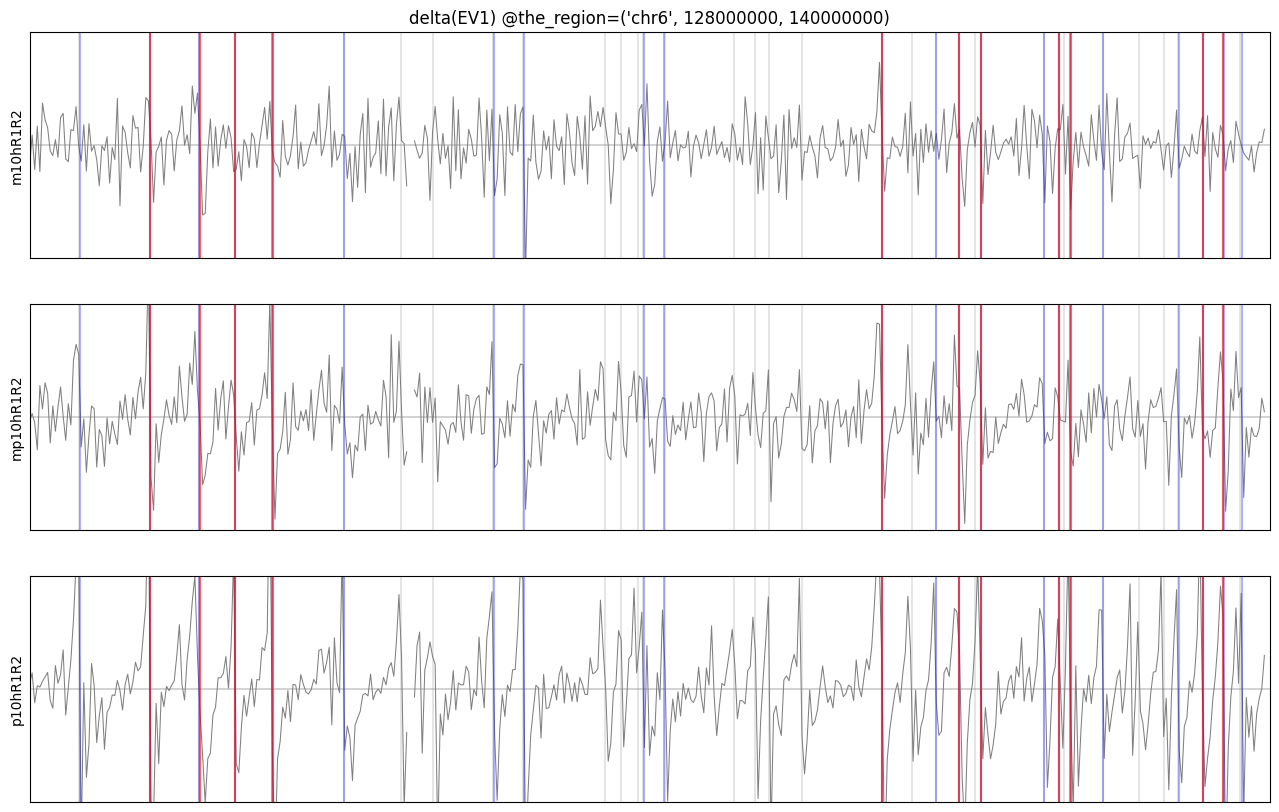

In [298]:
sub_samples =[
    "m10hR1R2",
    "mp10hR1R2",
    "p10hR1R2",
]


fig, axs = plt.subplots(
    nrows=len(sub_samples),
    ncols=1,
    figsize=(16,10),
    sharex=True,
    sharey=True,
)

# a contiguous region ...
the_region = hg38_arms.set_index("name").loc["chr12_p"]
#
_start = 128_000_000
_width = 12_000_000
the_region = ("chr6",_start,_start+_width)


# detect IDs in the region to show on the plots ...
# _anchors5 = id_anchors_dict["5hr_2X_enrichment_signal"]
# _anchorsCyto = id_anchors_dict["pCyto_2X_enrichment_signal"]
# MEGA_2X_enrichment
id_in_reg = bioframe.select(id_anchors_dict["MEGA_2X_enrichment"], the_region)
_id_bins_in_reg_MEGA = id_in_reg.eval("(start - @_start)/@binsize")
id_in_reg = bioframe.select(id_anchors_dict["pCyto_2X_enrichment_signal"], the_region)
_id_bins_in_reg_Cyto = id_in_reg.eval("(start - @_start)/@binsize")
id_in_reg = bioframe.select(id_anchors_dict["5hr_2X_enrichment_signal"], the_region)
_id_bins_in_reg_5hrs = id_in_reg.eval("(start - @_start)/@binsize")

for ii, sample, ax in zip(itertools.count(), sub_samples, axs):
    _eval, _eigs = telo_cis_eigs_gene[sample]
    # select for a region
    _eigs = bioframe.select(_eigs, the_region)
    # ax.plot([0,len(_eigs)],[0,0],'k',lw=0.25)
    # ax.plot([0,len(_eigs)],[0,0],'k',lw=0.25)
    ax.axhline(0,color='k',lw=0.25)
    ax.plot( np.arange(0, len(_eigs)-1), np.diff(_eigs['E1']), label='E1',linewidth=0.75, color="gray")
    # ...
    ax.set_xlim(0, len(_eigs))
    # ...
    ax.set_ylim(-0.5, 0.5)
    # ...
    ax.set_xticks([])
    ax.set_yticks([])
    if ii == 0:
        ax.set_title(f"delta(EV1) @{the_region=}")
    ax.set_ylabel(sample)
    for _id_bin in _id_bins_in_reg_MEGA:
        ax.axvline(_id_bin-1, alpha=0.2, color="grey")
    for _id_bin in _id_bins_in_reg_5hrs:
        ax.axvline(_id_bin-1, alpha=0.3, color="blue")
    for _id_bin in _id_bins_in_reg_Cyto:
        ax.axvline(_id_bin-1, alpha=0.6, color="red")


In [29]:
# lite wrapper around KMeans ...
from sklearn.cluster import KMeans
def get_cluster_labels(df, num_clust, subset_cols=None):
    """
     - small wrapper around KMeans ...

    receives a DataFrame, performs Kmeans clustering,
    treating rows as "samples" to be clustered and
    different columns as the coordinates of those "samples"

    returns a numpy array of cluster labels
    - corresponding to the DataFrame ...
    -1 stands for unclustered samples ...
    """
    if subset_cols is not None:
        X = df[subset_cols].to_numpy()
    else:
        # use all of the columns ...
        X = df.to_numpy()
    # ...
    # ...
    _nkluster = KMeans(n_clusters=num_clust)
    # we can cluster only real values,
    # mask all samples that have
    # at least 1 NaN coordinate
    real_samples_mask = np.all(~np.isnan(X), axis=1)
    # subset data to real samples only ...
    _X = X[real_samples_mask, :]
    # perform clustering ...
    kfit = _nkluster.fit(_X)
    # we've clsutered only non-NA samples
    # so we don't have any kfit.labels_ for the NaN-ed bins ...
    _labels_unmasked = np.zeros_like( real_samples_mask, dtype="int") - 1
    _labels_unmasked[real_samples_mask] = kfit.labels_
    # ...
    return _labels_unmasked

In [30]:
import datashader as ds, xarray as xr
from datashader import transfer_functions as tf, reductions as rd
from datashader.mpl_ext import dsshow, alpha_colormap

In [31]:
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [158]:
_, meigs = telo_cis_eigs_gene["m5hR1R2"]
_, peigs = telo_cis_eigs_gene["p5hR1R2"]
_, mpeigs = telo_cis_eigs_gene['mp10hR1R2']

# masking IDs with NaNs
# meval, meigs = telo_cis_eigs["m5hR1R2"]
# meigs.loc[_id_idxCommon,"E1"] = np.nan
# telo_cis_eigs["m5hR1R2"] = (meval, meigs)

# # a contiguous region ...
# the_region = hg38_arms.set_index("name").loc["chr2_p"]

# the_region = "chr6"
# meigs = bioframe.select(meigs, the_region)
# peigs = bioframe.select(peigs, the_region)
# mpeigs = bioframe.select(mpeigs, the_region)

_id_idx5 = bioframe.overlap(
    meigs,
    _anchors5,
    return_index=True,
    cols2=["chrom","peak_start","peak_end"],
).dropna(subset=["chrom_","start_","end_"])["index"].unique()
_id_idxCyto = bioframe.overlap(
    meigs,
    _anchorsCyto,
    return_index=True,
    cols2=["chrom","peak_start","peak_end"],
).dropna(subset=["chrom_","start_","end_"])["index"].unique()
# _id_idxCommon = np.unique(np.concatenate([_id_idx5, _id_idxCyto]))

# df = pd.DataFrame({ "m":meigs["E1"], "p":peigs["E1"] })
df = pd.DataFrame({
    "m":meigs["E1"], "p":peigs["E1"],
    "m2":meigs["E2"], "p2":peigs["E2"],
    # "m3":meigs["E3"], "p3":peigs["E3"],
})
df["cat"] = get_cluster_labels(df, num_clust=3)
df["cat"] = df["cat"].astype("category")


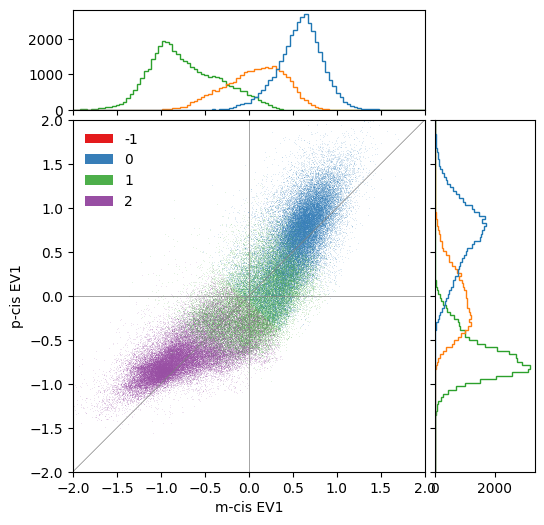

In [159]:
f, ax = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )

_evmin, _evmax = -2, 2
hist_kwargs = dict(
    bins=np.linspace(_evmin, _evmax, 100),
    # color=["grey","royalblue","crimson"],
    density=False,
    histtype="step",
)

_art = dsshow(
    df,
    ds.Point("m", "p"),
    ds.count_cat("cat"),
    norm='eq_hist',
    cmap="inferno",
    x_range=(_evmin, _evmax),
    y_range=(_evmin, _evmax),
    shade_hook=partial(tf.dynspread, threshold=np.log10(9.5145), how='over'),
    ax=ax,
)
ax.legend(handles=_art.get_legend_elements(), frameon=False)
# plt.title('Point category');

# # ax.invert_yaxis()
# # ax.invert_xaxis()
# _id_marker_size = 0.5
# for _color, _idx_subset in zip(["royalblue", "crimson"], [_id_idx5, _id_idxCyto]):
#     ax.scatter(
#         df.loc[_idx_subset, "m"],
#         df.loc[_idx_subset, "p"],
#         s=_id_marker_size,
#         alpha=0.8,
#         color=_color
#     )

ax.set_xlabel("m-cis EV1")
ax.set_ylabel("p-cis EV1")
_grid_kwargs = dict(color="grey", lw=0.5)
ax.axvline(0, **_grid_kwargs)
ax.axhline(0, **_grid_kwargs)
ax.plot([_evmin, _evmax],[_evmin, _evmax], **_grid_kwargs)
# ...
divider = make_axes_locatable(ax)
ax_x = divider.append_axes("top", size=1, pad=0.1, sharex=ax)
ax_y = divider.append_axes("right", size=1, pad=0.1, sharey=ax)
# # ...
# for ax, _type, _orient in zip([ax_x, ax_y], ["m", "p"], ["vertical", "horizontal"]):
#     ax.hist(
#         [df[ _type], df.loc[_id_idx5, _type], df.loc[_id_idxCyto, _type]],
#         orientation=_orient,
#         **hist_kwargs,
#     )
# # # ...
for ax, _type, _orient in zip([ax_x, ax_y], ["m", "p"], ["vertical", "horizontal"]):
    ax.hist(
        [g[_type] for i,g in df.groupby("cat", observed=True) if i != -1],
        orientation=_orient,
        **hist_kwargs,
    )
# make some labels invisible
ax_x.xaxis.set_tick_params(labelbottom=False)
ax_y.yaxis.set_tick_params(labelleft=False)



In [160]:
list(telo_cis_eigs_gene)

['mMito',
 'mTelo',
 'mCyto',
 'm5hR1R2',
 'm10hR1R2',
 'pMito',
 'pTelo',
 'pCyto',
 'p5hR1R2',
 'p10hR1R2',
 'mp10hR1R2',
 'N93m5',
 'N93m10',
 'N93p5',
 'N93p10',
 'N93mp10']

Text(0.5, 1.0, 'Cyto')

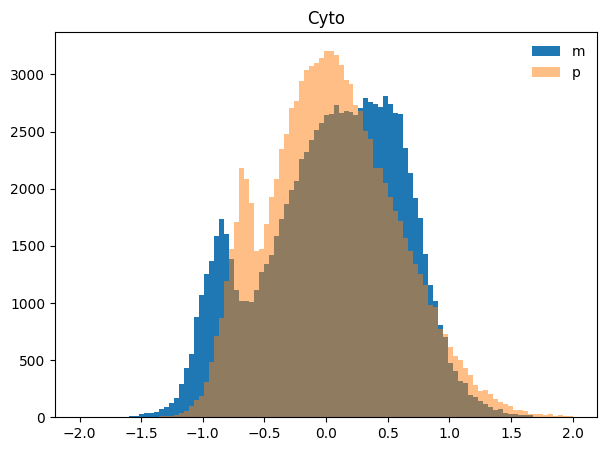

In [161]:
f, ax = plt.subplots( nrows=1, ncols=1, figsize=(7,5) )
bins=np.linspace(_evmin, _evmax, 100)


x = telo_cis_eigs_gene["mCyto"][1]["E1"]
y = telo_cis_eigs_gene["pCyto"][1]["E1"]
# z = telo_cis_eigs_gene['pCyto'][1]["E1"]

ax.hist(x, bins=bins, label="m")
ax.hist(y, bins=bins, alpha=0.5, label="p");
# ax.hist(z, bins=bins, alpha=0.5, label="mp");
ax.legend(frameon=False)
ax.set_title("Cyto")

Text(0.5, 1.0, '10hR1R2')

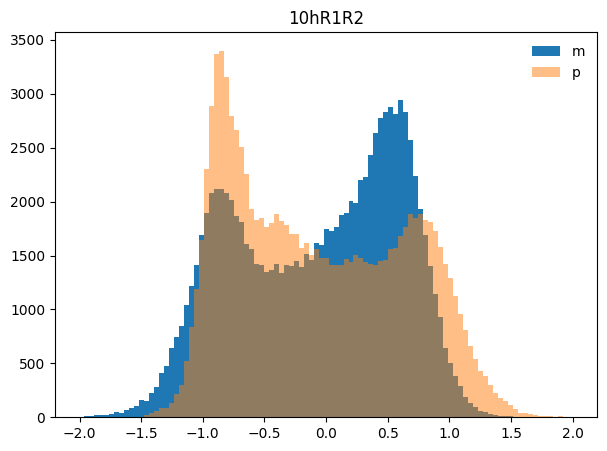

In [162]:
f, ax = plt.subplots( nrows=1, ncols=1, figsize=(7,5) )
bins=np.linspace(_evmin, _evmax, 100)


x = telo_cis_eigs_gene["m10hR1R2"][1]["E1"]
y = telo_cis_eigs_gene["p10hR1R2"][1]["E1"]
# z = telo_cis_eigs_gene['pCyto'][1]["E1"]

ax.hist(x, bins=bins, label="m")
ax.hist(y, bins=bins, alpha=0.5, label="p");
# ax.hist(z, bins=bins, alpha=0.5, label="mp");
ax.legend(frameon=False)
ax.set_title("10hR1R2")

Text(0.5, 1.0, '5hR1R2')

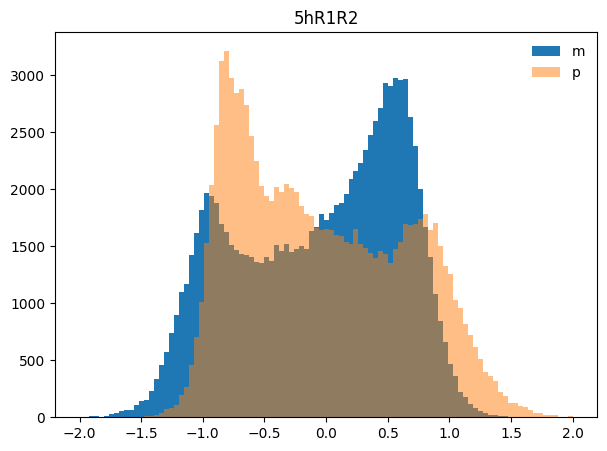

In [163]:
f, ax = plt.subplots( nrows=1, ncols=1, figsize=(7,5) )
bins=np.linspace(_evmin, _evmax, 100)


x = telo_cis_eigs_gene["m5hR1R2"][1]["E1"]
y = telo_cis_eigs_gene["p5hR1R2"][1]["E1"]
# z = telo_cis_eigs_gene['pCyto'][1]["E1"]

ax.hist(x, bins=bins, label="m")
ax.hist(y, bins=bins, alpha=0.5, label="p");
# ax.hist(z, bins=bins, alpha=0.5, label="mp");
ax.legend(frameon=False)
ax.set_title("5hR1R2")


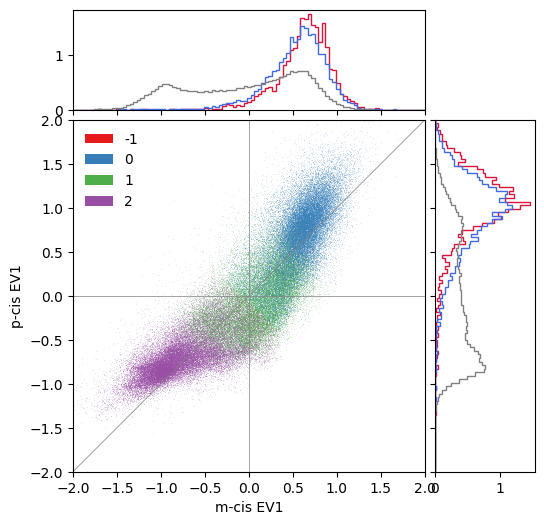

In [164]:
f, ax = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )

_evmin, _evmax = -2, 2
hist_kwargs = dict(
    bins=np.linspace(_evmin, _evmax, 100),
    color=["grey","royalblue","crimson"],
    density=True,
    histtype="step",
)

_art = dsshow(
    df,
    ds.Point("m", "p"),
    ds.count_cat("cat"),
    norm='eq_hist',
    cmap="inferno",
    x_range=(_evmin, _evmax),
    y_range=(_evmin, _evmax),
    shade_hook=partial(tf.dynspread, threshold=np.log10(9.5145), how='over'),
    ax=ax,
)
ax.legend(handles=_art.get_legend_elements(), frameon=False)
# plt.title('Point category');

_id_marker_size = 0.0
for _color, _idx_subset in zip(["royalblue", "crimson"], [_id_idx5, _id_idxCyto]):
    ax.scatter(
        df.loc[_idx_subset, "m"],
        df.loc[_idx_subset, "p"],
        s=_id_marker_size,
        alpha=0.8,
        color=_color
    )

ax.set_xlabel("m-cis EV1")
ax.set_ylabel("p-cis EV1")
_grid_kwargs = dict(color="grey", lw=0.5)
ax.axvline(0, **_grid_kwargs)
ax.axhline(0, **_grid_kwargs)
ax.plot([_evmin, _evmax],[_evmin, _evmax], **_grid_kwargs)
# ...
divider = make_axes_locatable(ax)
ax_x = divider.append_axes("top", size=1, pad=0.1, sharex=ax)
ax_y = divider.append_axes("right", size=1, pad=0.1, sharey=ax)
# ...
for ax, _type, _orient in zip([ax_x, ax_y], ["m", "p"], ["vertical", "horizontal"]):
    ax.hist(
        [df[ _type], df.loc[_id_idx5, _type], df.loc[_id_idxCyto, _type]],
        orientation=_orient,
        **hist_kwargs,
    )
# make some labels invisible
ax_x.xaxis.set_tick_params(labelbottom=False)
ax_y.yaxis.set_tick_params(labelleft=False)



In [165]:
df

,m,p,m2,p2,cat
0,NaN,NaN,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,-1
2,NaN,NaN,NaN,NaN,-1
3,NaN,NaN,NaN,NaN,-1
4,NaN,NaN,NaN,NaN,-1
...,...,...,...,...,...
115004,0.983269,0.422868,-0.267973,-0.692985,0
115005,0.967722,0.435830,-0.239960,-0.670059,0
115006,NaN,NaN,NaN,NaN,-1
115007,NaN,NaN,NaN,NaN,-1


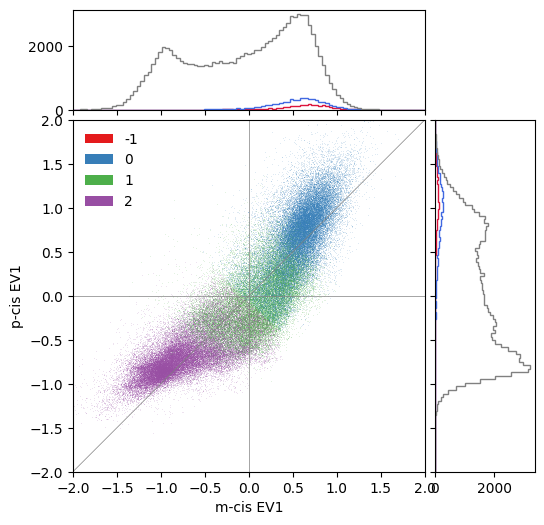

In [168]:
f, ax = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )

_evmin, _evmax = -2, 2
hist_kwargs = dict(
    bins=np.linspace(_evmin, _evmax, 100),
    color=["grey","royalblue","crimson"],
    density=False,
    histtype="step",
)

_art = dsshow(
    df,
    ds.Point("m", "p"),
    ds.count_cat("cat"),
    norm='eq_hist',
    cmap="inferno",
    x_range=(_evmin, _evmax),
    y_range=(_evmin, _evmax),
    shade_hook=partial(tf.dynspread, threshold=np.log10(9.5145), how='over'),
    ax=ax,
)
ax.legend(handles=_art.get_legend_elements(), frameon=False)
# plt.title('Point category');

_id_marker_size = 0.0
for _color, _idx_subset in zip(["royalblue", "crimson"], [_id_idx5, _id_idxCyto]):
    ax.scatter(
        df.loc[_idx_subset, "m"],
        df.loc[_idx_subset, "p"],
        s=_id_marker_size,
        alpha=0.8,
        color=_color
    )

ax.set_xlabel("m-cis EV1")
ax.set_ylabel("p-cis EV1")
_grid_kwargs = dict(color="grey", lw=0.5)
ax.axvline(0, **_grid_kwargs)
ax.axhline(0, **_grid_kwargs)
ax.plot([_evmin, _evmax],[_evmin, _evmax], **_grid_kwargs)
# ...
divider = make_axes_locatable(ax)
ax_x = divider.append_axes("top", size=1, pad=0.1, sharex=ax)
ax_y = divider.append_axes("right", size=1, pad=0.1, sharey=ax)
# ...
for ax, _type, _orient in zip([ax_x, ax_y], ["m", "p"], ["vertical", "horizontal"]):
    ax.hist(
        [df[ _type], df.loc[_id_idx5, _type], df.loc[_id_idxCyto, _type]],
        orientation=_orient,
        **hist_kwargs,
    )
# make some labels invisible
ax_x.xaxis.set_tick_params(labelbottom=False)
ax_y.yaxis.set_tick_params(labelleft=False)



In [44]:
# df = pd.DataFrame(
#     {
#         "m":meigs["E1"],
#         "p":peigs["E1"],
#         # "cat":0
#     }
# )
# # df.loc[_id_idx,"cat"] = 1
# # df["cat"] = df["cat"].astype("category")

# f,axs = plt.subplots(nrows=1,ncols=2, figsize=(12,6),sharex=True,sharey=True)

# ax = axs[0]
# _art = dsshow(
#     df,
#     ds.Point("m", "p"),
#     # ds.count_cat("cat"),
#     norm='eq_hist',
#     cmap="inferno",
#     x_range=(-2,2),
#     y_range=(-2,2),
#     ax=ax,
# )
# ax.scatter(
#     df.loc[_id_idx5,"m"],
#     df.loc[_id_idx5,"p"],
#     s=0.2,
#     alpha=0.8,
#     color="royalblue"
# )
# ax.scatter(
#     df.loc[_id_idxCyto,"m"],
#     df.loc[_id_idxCyto,"p"],
#     s=0.2,
#     alpha=0.8,
#     color="crimson"
# )
# ax.set_xlabel("m-cis EV1")
# ax.set_ylabel("p-cis EV1")
# ax.axvline(0, color="grey", lw=0.5)
# ax.axhline(0, color="grey", lw=0.5)
# ax.plot([-2,2],[-2,2], color="grey", lw=0.5)
# #
# divider = make_axes_locatable(ax)
# ax_x = divider.append_axes("top", size=1, pad=0.1, sharex=ax)
# ax_y = divider.append_axes("right", size=1, pad=0.1, sharey=ax)

# # ax_x.hist(df["m"],bins=np.linspace(-2,2,100),alpha=0.5,color="grey")
# # ax_x.hist(df.loc[_id_idx5,"m"],bins=np.linspace(-2,2,100),color="royalblue")
# # ax_x.hist(df.loc[_id_idxCyto,"m"],bins=np.linspace(-2,2,100),color="crimson")

# ax_x.hist(
#     [df["m"], df.loc[_id_idx5,"m"], df.loc[_id_idxCyto,"m"]],
#     bins=np.linspace(-2,2,100),
#     # alpha=0.5,
#     color=["grey","royalblue","crimson"],
#     orientation="vertical",
#     density=True,
#     histtype="step",
#     # stacked=True
# )


# ax_y.hist(
#     [df["p"], df.loc[_id_idx5,"p"], df.loc[_id_idxCyto,"p"]],
#     bins=np.linspace(-2,2,100),
#     # alpha=0.5,
#     color=["grey","royalblue","crimson"],
#     orientation="horizontal",
#     density=True,
#     histtype="step",
#     # stacked=True
# )

# ax_x.set_xlim(-2,2)
# # ax_y.set_ylim(-2,2)

# ax = axs[1]
# _art = dsshow(
#     df.drop(_id_idxCommon, axis=0),
#     # df,
#     ds.Point("m", "p"),
#     # ds.count_cat("cat"),
#     norm='log',
#     cmap="inferno_r",
#     x_range=(-2,2),
#     y_range=(-2,2),
#     ax=ax,
# )
# ax.axvline(0, color="grey", lw=0.5)
# ax.axhline(0, color="grey", lw=0.5)
# ax.plot([-2,2],[-2,2], color="grey", lw=0.5)

# divider = make_axes_locatable(ax)
# ax_x = divider.append_axes("top", size=1, pad=0.1, sharex=ax)
# ax_y = divider.append_axes("right", size=1, pad=0.1, sharey=ax)
# # # create new axes on the right and on the top of the current axes.
# # divider = make_axes_locatable(axb)
# # axb_x = divider.append_axes("bottom", size=0.12, pad=0.00, sharex=axb)
# # axb_y = divider.append_axes("left", size=0.12, pad=0.00, sharey=axb)
# # # create new axes on the right and on the top of the current axes.
# ax_x.hist(df.drop(_id_idxCommon, axis=0)["m"],bins=np.linspace(-2,2,100))
# ax_y.hist(df.drop(_id_idxCommon, axis=0)["p"],bins=np.linspace(-2,2,100), orientation="horizontal")
# ax_x.set_xlim(-2,2)
# # ax_y.set_ylim(-2,2)



### Cross correlation of the EV1 for selected regions and genome-wide

<Axes: >

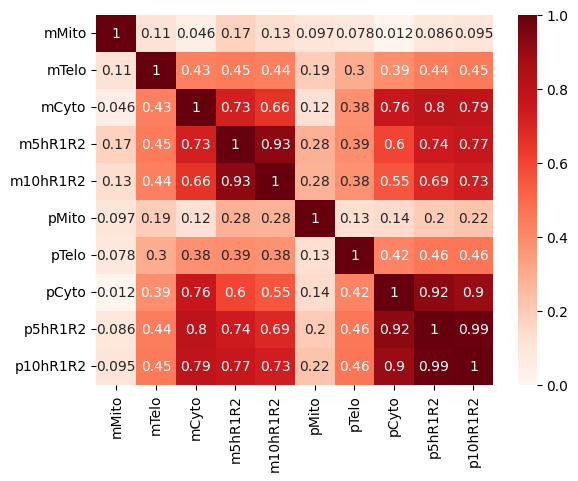

In [46]:
ddd = {}
for sample in sub_samples_m+sub_samples_p:
    eval, eigs = telo_cis_eigs_gene[sample]

    ddd[sample] = bioframe.select(eigs, the_region)["E1"]
    # ddd[sample] = eigs["E1"]

sns.heatmap(pd.DataFrame(ddd).corr(method='pearson'), annot=True, cmap="Reds",vmin=0,vmax=1)



<Axes: >

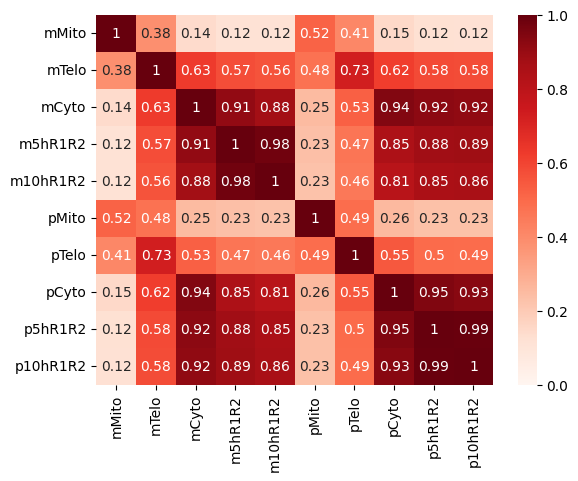

In [47]:
ddd = {}
for sample in sub_samples_m+sub_samples_p:
    eval, eigs = telo_cis_eigs_gene[sample]

    # ddd[sample] = bioframe.select(eigs, the_region)["E1"]
    ddd[sample] = eigs["E1"]

sns.heatmap(pd.DataFrame(ddd).corr(method='pearson'), annot=True, cmap="Reds",vmin=0,vmax=1)



### Look at eigenvalues jusat for fun ...

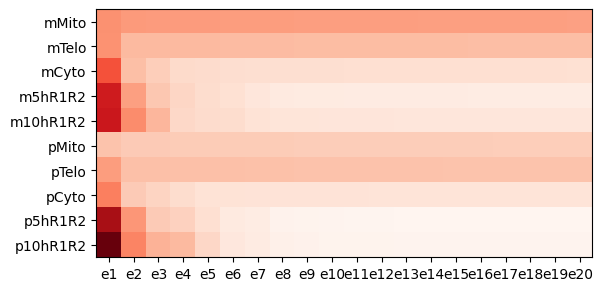

In [48]:
ddd = {}
numevals = 20
for sample in sub_samples_m+sub_samples_p:
    eval, eigs = telo_cis_eigs_gene[sample]

    # ddd[sample] = bioframe.select(eigs, the_region)["E1"]
    ddd[sample] = eval.query("name == 'chr6_q'")[[f"eigval{i}" for i in range(1,numevals+1)]]

# sns.heatmap(pd.DataFrame(ddd).corr(method='spearman'), annot=True, cmap="Reds",vmin=0,vmax=1)
plt.imshow(pd.concat(ddd).abs(), cmap="Reds")

ax = plt.gca()
ax.set_yticks(np.arange(len(sub_samples_m+sub_samples_p)))
ax.set_yticklabels(sub_samples_m+sub_samples_p)

ax.set_xticks(np.arange(numevals))
ax.set_xticklabels([f"e{i}" for i in range(1,numevals+1)]);

Plotting the first eigenvector next to the Hi-C map allows us to see how this captures the plaid pattern. 

To better visualize this relationship, we overlay the map with a binary segmentation of the eigenvector. Eigenvectors can be segmented by a variety of methods. The simplest segmentation, shown here, is to simply binarize eigenvectors, and term everything above zero the "A-compartment" and everything below 0 the "B-compartment".


## Saddleplots

A common way to visualize preferences captured by the eigenvector is by using saddleplots.

To generate a saddleplot, we first use the eigenvector to stratify genomic regions into groups with similar values of the eigenvector. These groups are then averaged over to create the saddleplot.
This process is called "digitizing".

Cooltools will operate with `digitized` bedgraph-like track with four columns. The fourth, or value, column is a categorical, as shown above for the first three bins. Categories have the following encoding:

    - `1..n` <-> values assigned to bins defined by vrange or qrange
    - `0` <-> left outlier values
    - `n+1` <-> right outlier values
    - `-1` <-> missing data (NaNs)
    
Track values can either be digitized by numeric values, by passing `vrange`, or by quantiles, by passing `qrange`, as above.

To create saddles in cis with `saddle`, cooltools requires: a cooler, a table with expected as function of distance, and parameters for digitizing:

In [49]:
telo_trans_filt_exps = {}
for _k, _clr in tqdm(telo_clrs.items()):
    _df = telo_exps_trans[_k].reset_index()
    m2 = _df["region2"].isin(["chrX","chrY","chrM"])
    m1 = _df["region1"].isin(["chrX","chrY","chrM"])
    telo_trans_filt_exps[_k] = _df[~(m1 | m2)]

# a view without M,X and Y chromosomes ...
sub_chrom_view = bioframe.make_viewframe(hg38_chromsizes)
bad_chroms = ["chrX","chrY","chrM"]
sub_chrom_view = sub_chrom_view[~sub_chrom_view["name"].isin(bad_chroms)]

  0%|          | 0/16 [00:00<?, ?it/s]

In [50]:
# Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
# Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
# N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each

`saddle` then returns two matrices: one with the sum for each pair of categories, `interaction_sum`, and the other with the number of bins for each pair of categories, `interaction_count`. Typically, `interaction_sum`/`interaction_count` is visualized. 


In [51]:
# telo_cis_eigs.keys()

In [336]:
def _job(packed_data, sample):
    Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
    Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
    N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each
    # packed data -> exp_kwargs and a dict with coolers for each sample
    clr_dict, exp_dict, eigs_dict, view_df = packed_data
    _clr = clr_dict[sample]
    _exp = exp_dict[sample]
    # _track = eigs_dict["m5hR1R2"][1][["chrom","start","end","E1"]]
    if any( (_ in sample) for _ in ["Mito", "Telo", "Cyto"] ):
        if sample.startswith("m"):
            _track = eigs_dict["m5hR1R2"][1][["chrom","start","end","E1"]]
        elif sample.startswith("p"):
            _track = eigs_dict["p5hR1R2"][1][["chrom","start","end","E1"]]
        else:
            print("what da heck ?!")
    else:
        _track = eigs_dict[sample][1][["chrom","start","end","E1"]]
    # # in order to use spawn/forkserver we have to import for worker
    # # from cooltools import saddle
    from cooltools.api.saddle import saddle_stack
    _sum, _count = saddle_stack(
        _clr,
        _exp,
        _track,
        'cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
    )
    #
    return sample, _sum, _count

# have to use daemon=False, because _job is multiprocessing-based already ...
with WorkerPool(
    n_jobs=16,
    daemon=True,
    shared_objects=( telo_clrs, telo_exps_cis, telo_cis_eigs_gene, hg38_arms ),
    start_method="fork",  # little faster than spawn, fork is the fastest
    use_dill=True,
) as wpool:
    results = wpool.map(_job, telo_clrs, progress_bar=True)

# sort out the results ...
interaction_sums = {}
interaction_counts = {}
for sample, _sum, _counts in results:
    interaction_sums[sample] = _sum
    interaction_counts[sample] = _counts


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:39<00:00,  1.46s/it]


In [337]:
def _job(packed_data, sample):
    Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
    Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
    N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each
    # packed data -> exp_kwargs and a dict with coolers for each sample
    clr_dict, exp_dict, eigs_dict, view_df = packed_data
    _clr = clr_dict[sample]
    _exp = exp_dict[sample]
    # _track = eigs_dict["m5hR1R2"][1][["chrom","start","end","E1"]]
    if any( (_ in sample) for _ in ["Mito", "Telo", "Cyto"] ):
        if sample.startswith("m"):
            _track = eigs_dict["m5hR1R2"][1][["chrom","start","end","E1"]]
        elif sample.startswith("p"):
            _track = eigs_dict["p5hR1R2"][1][["chrom","start","end","E1"]]
        else:
            print("what da heck ?!")
    else:
        _track = eigs_dict[sample][1][["chrom","start","end","E1"]]
    # # in order to use spawn/forkserver we have to import for worker
    # # from cooltools import saddle
    from cooltools.api.saddle import saddle_stack
    _sum, _count = saddle_stack(
        _clr,
        _exp,
        _track,
        'trans',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=view_df
    )
    #
    return sample, _sum, _count

# have to use daemon=False, because _job is multiprocessing-based already ...
with WorkerPool(
    n_jobs=16,
    daemon=True,
    shared_objects=( telo_clrs, telo_trans_filt_exps, telo_cis_eigs_gene, sub_chrom_view ),
    start_method="fork",  # little faster than spawn, fork is the fastest
    use_dill=True,
) as wpool:
    results = wpool.map(_job, telo_clrs, progress_bar=True)

# sort out the results ...
interaction_sums_trans = {}
interaction_counts_trans = {}
for sample, _sum, _counts in results:
    interaction_sums_trans[sample] = _sum
    interaction_counts_trans[sample] = _counts

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [10:32<00:00, 19.19s/it]


There are multiple ways to plot saddle data, one useful way is shown below. 
This visualization includes histograms of the number of bins contributing to each row/column of the saddleplot.

The saddle below shows average observed/expected contact frequency between regions grouped according to their digitized eigenvector values with a blue-to-white-to-red colormap. Inactive regions (i.e. low digitized values) are on the top and left, and active regions (i.e. high digitized values) are on the bottom and right. 

The saddleplot shows that inactive regions are enriched for contact frequency with other inactive regions (red area in the upper left), and active regions are enriched for contact frequency with other active regions (red area in the lower right). In contrast, active regions are depleted for contact frequency with inactive regions (blue area in top right and bottom left). 

/tmp/ipykernel_954044/3545018158.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xxxm = digitized_track.groupby("value.d")["value"].mean()
/tmp/ipykernel_954044/3545018158.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xxxp = digitized_track.groupby("value.d")["value"].mean()


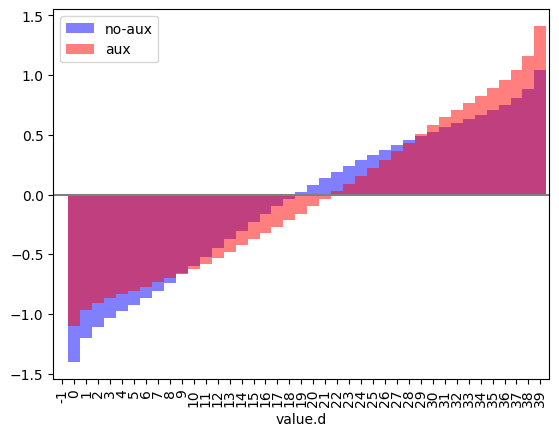

In [364]:
# let's check how digitization goes here ...
from cooltools.api.saddle import align_track_with_cooler, digitize
from cooltools.api.saddle import saddle_stack

Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each
n_bins = N_GROUPS

# telo_cis_eigs_gene["m5hR1R2"][1][["chrom","start","end","E1"]]

vrange = (-2.5,2.5)
qrange=(Q_LO,Q_HI)


track = align_track_with_cooler(
    telo_cis_eigs_gene["m5hR1R2"][1][["chrom","start","end","E1"]],
    telo_clrs["m5hR1R2"],
    view_df=hg38_arms,
    clr_weight_name="weight",
    mask_clr_bad_bins=True,
    drop_track_na=False,  # this adds check for chromosomes that have all missing values
)
digitized_track, binedges = digitize(
    track.iloc[:, :4],
    n_bins,
    # vrange=vrange,
    qrange=qrange,
    digitized_suffix=".d",
)
digitized_track["value"] = track["value"]
xxxm = digitized_track.groupby("value.d")["value"].mean()

track = align_track_with_cooler(
    telo_cis_eigs_gene["p5hR1R2"][1][["chrom","start","end","E1"]],
    telo_clrs["p5hR1R2"],
    view_df=hg38_arms,
    clr_weight_name="weight",
    mask_clr_bad_bins=True,
    drop_track_na=False,  # this adds check for chromosomes that have all missing values
)
digitized_track, binedges = digitize(
    track.iloc[:, :4],
    n_bins,
    # vrange=vrange,
    qrange=qrange,
    digitized_suffix=".d",
)
digitized_track["value"] = track["value"]
xxxp = digitized_track.groupby("value.d")["value"].mean()

xxxm.plot(kind="bar",width=1,color="blue",label="no-aux",alpha=0.5)#,lw=0.5,marker="s",label="no-aux")
xxxp.plot(kind="bar",width=1,color="red",label="aux",alpha=0.5)#.plot(lw=0.5,marker="s",label="aux")
ax = plt.gca()
ax.axhline(0,color="grey")
plt.legend()

In [594]:
for s in telo_clrs:
    print(s)

mMito
mTelo
mCyto
m5hR1R2
m10hR1R2
pMito
pTelo
pCyto
p5hR1R2
p10hR1R2
mp10hR1R2
N93m5
N93m10
N93p5
N93p10
N93mp10


In [599]:
! ls -l digitized_ev

total 83536
-rw-r----- 1 sergpolly sergpolly 5337811 Apr  5 15:01 m10hR1R2.tsv
-rw-r----- 1 sergpolly sergpolly 5343353 Apr  5 15:01 m5hR1R2.tsv
-rw-r----- 1 sergpolly sergpolly 5337795 Apr  5 15:01 mCyto.tsv
-rw-r----- 1 sergpolly sergpolly 5376236 Apr  5 15:01 mMito.tsv
-rw-r----- 1 sergpolly sergpolly 5340259 Apr  5 15:01 mp10hR1R2.tsv
-rw-r----- 1 sergpolly sergpolly 5369979 Apr  5 15:01 mTelo.tsv
-rw-r----- 1 sergpolly sergpolly 5316358 Apr  5 15:01 N93m10.tsv
-rw-r----- 1 sergpolly sergpolly 5322592 Apr  5 15:01 N93m5.tsv
-rw-r----- 1 sergpolly sergpolly 5321399 Apr  5 15:01 N93mp10.tsv
-rw-r----- 1 sergpolly sergpolly 5317598 Apr  5 15:01 N93p10.tsv
-rw-r----- 1 sergpolly sergpolly 5314984 Apr  5 15:01 N93p5.tsv
-rw-r----- 1 sergpolly sergpolly 5340927 Apr  5 15:01 p10hR1R2.tsv
-rw-r----- 1 sergpolly sergpolly 5350264 Apr  5 15:01 p5hR1R2.tsv
-rw-r----- 1 sergpolly sergpolly 5358307 Apr  5 15:01 pCyto.tsv
-rw-r----- 1 sergpolly sergpolly 5383314 Apr  5 15:01 pMito.tsv
-rw-r-----

In [598]:
for _sample in telo_clrs:
    track = align_track_with_cooler(
        telo_cis_eigs_gene[_sample][1][["chrom","start","end","E1"]],
        telo_clrs[_sample],
        view_df=hg38_arms,
        clr_weight_name="weight",
        mask_clr_bad_bins=True,
        drop_track_na=False,  # this adds check for chromosomes that have all missing values
    )
    digitized_track, binedges = digitize(
        track.iloc[:, :4],
        n_bins,
        qrange=qrange,
        digitized_suffix=".d",
    )
    digitized_track["value"] = track["value"]
    print(f"saving {_sample} ...")
    # print(digitized_track)
    digitized_track.to_csv(f"./digitized_ev/{_sample}.tsv", sep="\t", index=False)
    # xxxm = digitized_track.groupby("value.d")["value"].mean()


saving mMito ...
saving mTelo ...
saving mCyto ...
saving m5hR1R2 ...
saving m10hR1R2 ...
saving pMito ...
saving pTelo ...
saving pCyto ...
saving p5hR1R2 ...
saving p10hR1R2 ...
saving mp10hR1R2 ...
saving N93m5 ...
saving N93m10 ...
saving N93p5 ...
saving N93p10 ...
saving N93mp10 ...


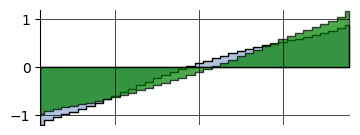

In [469]:
f = plt.figure(figsize=(4,1.5))
ax = f.add_subplot()
data = xxxm.loc[1:38]
ax.fill_between(data.index, data, 0, color="lightsteelblue", ec="black",step="mid")
ax.set_ylim(-1.2,1.2)
ax.set_xlim(1,38.1)
ax.spines[:].set_visible(False)
ax.spines["left"].set_visible(True)
ax.tick_params(bottom=False,left=True,labelbottom=False)
# ax.set_frame_on(False)
# plt.axis("off")
ax.grid(color="black",lw=0.5)


#####################################################################

# f = plt.figure(figsize=(4,1.5))
# ax = f.add_subplot()
data = xxxp.loc[1:38]
ax.fill_between(data.index, data, 0, color="green", ec="black",step="mid",alpha=0.7)
ax.set_ylim(-1.2,1.2)
ax.set_xlim(1,38.1)
ax.spines[:].set_visible(False)
ax.spines["left"].set_visible(True)
ax.tick_params(bottom=False,left=True,labelbottom=False)
# ax.set_frame_on(False)
# plt.axis("off")
ax.grid(color="black",lw=0.5)

In [345]:
# fig, axs = plt.subplots(
#     nrows=len(sub_samples_m),
#     ncols=2,
#     figsize=(4,12),
#     sharex=True,
#     sharey=True,
# )

# imshow_kwargs = dict(
#         norm=LogNorm(vmin=1/3, vmax=3),
#         cmap="RdBu_r",
#         interpolation="nearest",
# )

# min_diag, max_diag = 0,-1

# for sample_m, sample_p, (i, axs) in zip(sub_samples_m, sub_samples_p, enumerate(axs)):
#     axm,axp = axs
#     Cm = np.divide(
#         np.nanmean(interaction_sums[sample_m][min_diag:max_diag], axis=0),
#         np.nanmean(interaction_counts[sample_m][min_diag:max_diag], axis=0)
#     )
#     Cp = np.divide(
#         np.nanmean(interaction_sums[sample_p][min_diag:max_diag], axis=0),
#         np.nanmean(interaction_counts[sample_p][min_diag:max_diag], axis=0)
#     )
#     axm.imshow(Cm[1:-1,1:-1], **imshow_kwargs)
#     axp.imshow(Cp[1:-1,1:-1], **imshow_kwargs)
#     axm.set_xticks([])
#     axm.set_yticks([])
#     axp.set_xticks([])
#     axp.set_yticks([])
#     if i == 0:
#         axm.set_title("m")
#         axp.set_title("p")
#     axm.set_ylabel(sample_m.lstrip("m"))

# fig.suptitle(f"cis saddles: {int((min_diag*binsize)//1_000_000)}-{int((max_diag*binsize)//1_000_000)} Mb")

In [346]:

# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))




def get_saddle_data(sample, dist_name, dist_range=None):
    """
    little convenience func - to turn local interaction_sums and interaction_counts
    into saddle data ...
    """
    if dist_name == "trans":
        _sum = np.nansum(interaction_sums_trans[sample], axis=0)
        _count = np.nansum(interaction_counts_trans[sample], axis=0)
    else:
        if dist_range is not None:
            _sum = np.nansum(interaction_sums[sample][dist_range], axis=0)
            _count = np.nansum(interaction_counts[sample][dist_range], axis=0)
        else:
            _sum = np.nansum(interaction_sums[sample], axis=0)
            _count = np.nansum(interaction_counts[sample], axis=0)
    return _sum / _count


imshow_kwargs = dict(
        # norm=LogNorm(vmin=1/5, vmax=5),
        norm=MidPointLogNorm(vmin=1/5, vmax=3, midpoint=1),
        cmap="RdBu_r",
        interpolation="none",
)


# # # introduce distance ranges
# # # 0-1mb: 0:21 bins
# # # 1-7Mb: 21:141 bins
# # # 7-50Mb: 141:1001 bins
# # # trans: : bins
# distances = {
#     "short:<1MB": slice(0, int(1_000_000/binsize)+1),
#     "mid:1MB-7Mb": slice(int(1_000_000/binsize), int(7_000_000/binsize)+1),
#     "long7Mb-50Mb": slice(int(7_000_000/binsize), int(50_000_000/binsize)+1),
#     "trans": slice(None),
# }
distances = {
    "all-cis": slice(None),
    "trans": slice(None),
}


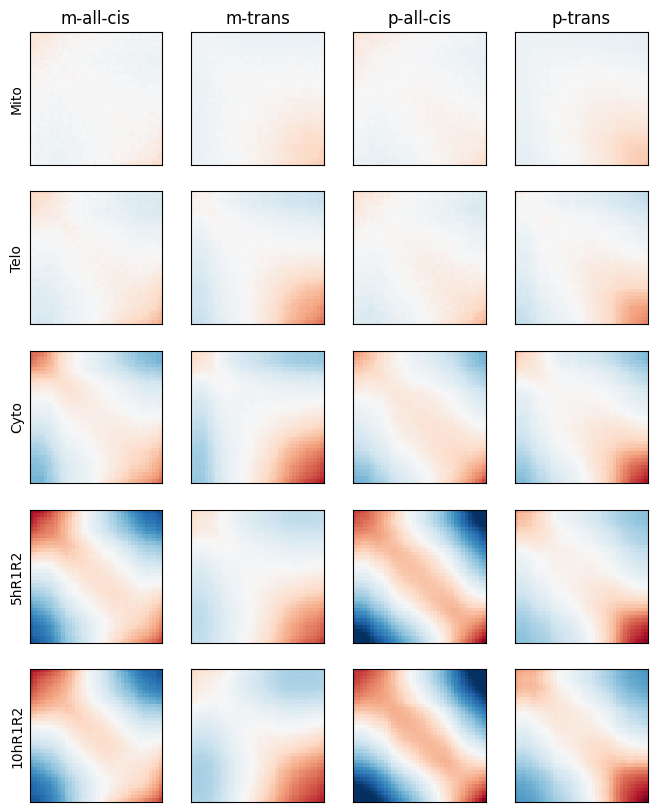

In [347]:
sub_samples_m = [
    "mMito",
    "mTelo",
    "mCyto",
    "m5hR1R2",
    "m10hR1R2",
]
sub_samples_p = [
    "pMito",
    "pTelo",
    "pCyto",
    "p5hR1R2",
    "p10hR1R2",
]

fig, axs = plt.subplots(
    nrows=len(sub_samples_m),
    ncols=2*len(distances),
    figsize=(4*len(distances),2*len(sub_samples_m)),
    sharex=True,
    sharey=True,
)

for sample_m, sample_p, (i, _axs) in zip(sub_samples_m, sub_samples_p, enumerate(axs)):
    for jj, (_dist_name, _dist) in enumerate(distances.items()):
        axm, axp = _axs[jj], _axs[len(distances) + jj]
        Cm = get_saddle_data(sample_m, _dist_name, _dist)
        Cp = get_saddle_data(sample_p, _dist_name, _dist)
        axm.imshow(Cm[1:-1,1:-1], **imshow_kwargs)
        axp.imshow(Cp[1:-1,1:-1], **imshow_kwargs)

# annotate labels and titles ...
for jj, _dist_name in enumerate(distances):
    # m ...
    axs[0, jj].set_title(f"m-{_dist_name}")
    # p ...
    axs[0, len(distances) + jj].set_title(f"p-{_dist_name}")
for ii, _sample in enumerate(sub_samples_m):
    axs[ii,0].set_ylabel(_sample.lstrip("m"))
    axs[ii,0].set_yticks([])
    axs[ii,0].set_xticks([])


In [348]:
def saddle_strength(k, sample, dist_name, dist_range=None):
    """
    ...
    """
    if dist_name == "trans":
        S = np.nansum(interaction_sums_trans[sample], axis=0)
        C = np.nansum(interaction_counts_trans[sample], axis=0)
    else:
        if dist_range is not None:
            S = np.nansum(interaction_sums[sample][dist_range], axis=0)
            C = np.nansum(interaction_counts[sample][dist_range], axis=0)
        else:
            S = np.nansum(interaction_sums[sample], axis=0)
            C = np.nansum(interaction_counts[sample], axis=0)

    # ...
    S = S[1:-1,1:-1]
    C = C[1:-1,1:-1]

    m, n = S.shape
    if m != n:
        raise ValueError("`saddledata` should be square.")

    intra_BB = np.nansum(S[0:k, 0:k]) / np.nansum(C[0:k, 0:k])
    intra_AA = np.nansum(S[n - k : n, n - k : n]) / np.nansum(C[n - k : n, n - k : n])
    intra_all = (np.nansum(S[0:k, 0:k])+np.nansum(S[n - k : n, n - k : n])) \
                / (np.nansum(C[0:k, 0:k])+np.nansum(C[n - k : n, n - k : n]))

    inter_sum = np.nansum(S[0:k, n - k : n]) + np.nansum(S[n - k : n, 0:k])
    inter_count = np.nansum(C[0:k, n - k : n]) + np.nansum(C[n - k : n, 0:k])
    inter = inter_sum / inter_count

    # return pd.Series({"AA" : intra_AA, "BB" : intra_BB})
    # return pd.Series({"AA" : intra_AA/inter, "BB" : intra_BB/inter,})
    return pd.Series({"AA" : intra_AA/inter, "BB" : intra_BB/inter, "AandB": intra_all/inter})
    # return pd.Series({"all": intra_all/inter})

In [349]:
# # # introduce distance ranges
# # # 0-1mb: 0:21 bins
# # # 1-7Mb: 21:141 bins
# # # 7-50Mb: 141:1001 bins
# # # trans: : bins
distances = {
    "all-cis": slice(None),
    "trans": slice(None),
}
# distances = {
#     "short:<3MB": slice(0, int(3_000_000/binsize)+1),
#     # "mid:1MB-7Mb": slice(int(1_000_000/binsize), int(7_000_000/binsize)+1),
#     "long3Mb-50Mb": slice(int(3_000_000/binsize), int(50_000_000/binsize)+1),
#     "trans": slice(None),
# }

_dfs_m = {}
_dfs_p = {}
for _dist in distances:
    _dfs_m[_dist] = {}
    _dfs_p[_dist] = {}

for sample_m, sample_p in zip(sub_samples_m, sub_samples_p):
    for _dist_name, _dist in distances.items():
        _sm = saddle_strength(k=11, sample=sample_m, dist_name=_dist_name, dist_range=_dist)
        _sp = saddle_strength(k=11, sample=sample_p, dist_name=_dist_name, dist_range=_dist)
        #
        _dfs_m[_dist_name][sample_m] = _sm
        _dfs_p[_dist_name][sample_p] = _sp

dfm = pd.concat([pd.DataFrame(_dfs_m[_dist]).T.add_suffix(f"-{_dist}") for _dist in distances], axis=1)
dfm.index = [ii.lstrip("m") for ii in dfm.index]
dfm = dfm.add_prefix("ctrl::")
dfp = pd.concat([pd.DataFrame(_dfs_p[_dist]).T.add_suffix(f"-{_dist}") for _dist in distances], axis=1)
dfp.index = [ii.lstrip("p") for ii in dfp.index]
dfp = dfp.add_prefix("delta::")


In [353]:
pd.concat([dfm, dfp], axis=1).to_csv("their_own_EV1_k11_comp_strength.tsv", sep="\t")

## Introduce "fake" time to convey the duration of the Cyto->G1 transition ...

In [351]:
_time = [0,1,2,5,6]
dfm["time"] = _time
dfp["time"] = _time

dfm = dfm.set_index("time")
dfp = dfp.set_index("time")

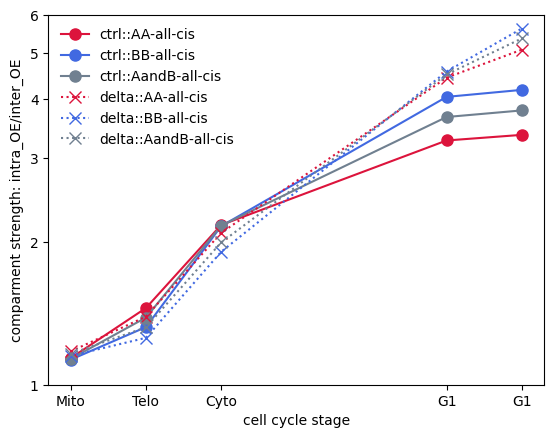

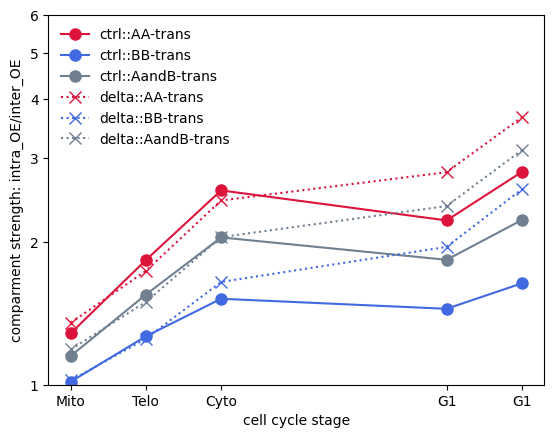

In [352]:
aabb_colors = ["crimson","royalblue", "slategrey"]
# aabb_colors = ["slategrey","royalblue", "green"]

for _sub in distances:
    dfm.filter(like=_sub).plot(
        color=aabb_colors,
        markersize=8,
        marker="o",
    )
    ax = plt.gca()
    dfp.filter(like=_sub).plot(
        ax=ax,
        color=aabb_colors,
        marker="x",
        markersize=9,
        linestyle=":",
    )
    ax.set_ylim(1,2)
    ax.legend(frameon=False)
    ax.set_xticks(_time)
    ax.set_xticklabels(["Mito", "Telo", "Cyto", "G1", "G1"])
    ax.set_yscale("log")
    ax.set_yticks([1,2,3,4,5,6])
    ax.set_xlabel("cell cycle stage")
    # ax.set_yticks([1,2])
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.minorticks_off()
    # ax.set_ylabel("intra_OE")
    ax.set_ylabel("comparment strength: intra_OE/inter_OE")

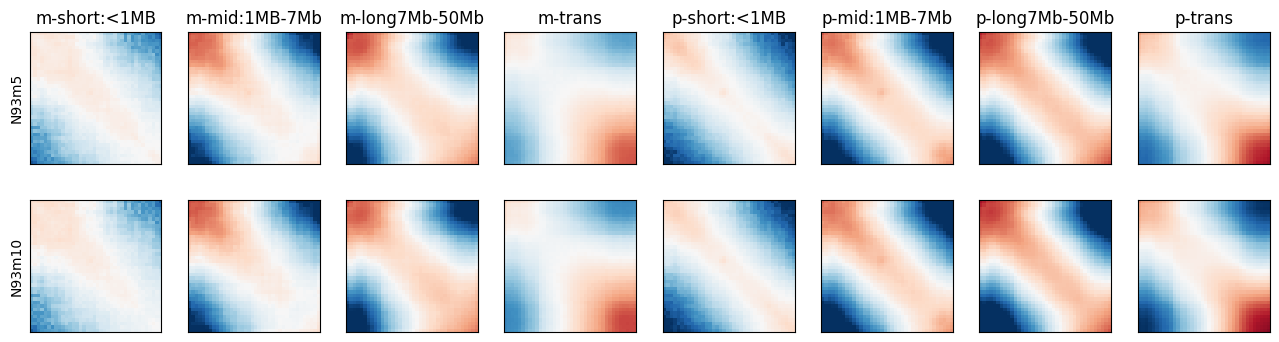

In [274]:
# # # # the mix one - mp
sub_samples_m = [
    "N93m5",
    "N93m10",
]
# p ...
sub_samples_p = [
    "N93p5",
    "N93p10",
]


# # introduce distance ranges
# # 0-1mb: 0:21 bins
# # 1-7Mb: 21:141 bins
# # 7-50Mb: 141:1001 bins
# # trans: : bins
distances = {
    "short:<1MB": slice(0, int(1_000_000/binsize)+1),
    "mid:1MB-7Mb": slice(int(1_000_000/binsize), int(7_000_000/binsize)+1),
    "long7Mb-50Mb": slice(int(7_000_000/binsize), int(50_000_000/binsize)+1),
    "trans": slice(None),
}


fig, axs = plt.subplots(
    nrows=len(sub_samples_m),
    ncols=2*len(distances),
    figsize=(4*len(distances),2*len(sub_samples_m)),
    sharex=True,
    sharey=True,
)

for sample_m, sample_p, (i, _axs) in zip(sub_samples_m, sub_samples_p, enumerate(axs)):
    for jj, (_dist_name, _dist) in enumerate(distances.items()):
        axm, axp = _axs[jj], _axs[len(distances) + jj]
        Cm = get_saddle_data(sample_m, _dist_name, _dist)
        Cp = get_saddle_data(sample_p, _dist_name, _dist)
        axm.imshow(Cm[1:-1,1:-1], **imshow_kwargs)
        axp.imshow(Cp[1:-1,1:-1], **imshow_kwargs)

# annotate labels and titles ...
for jj, _dist_name in enumerate(distances):
    # m ...
    axs[0, jj].set_title(f"m-{_dist_name}")
    # p ...
    axs[0, len(distances) + jj].set_title(f"p-{_dist_name}")
for ii, _sample in enumerate(sub_samples_m):
    axs[ii,0].set_ylabel(_sample.lstrip("m"))
    axs[ii,0].set_yticks([])
    axs[ii,0].set_xticks([])


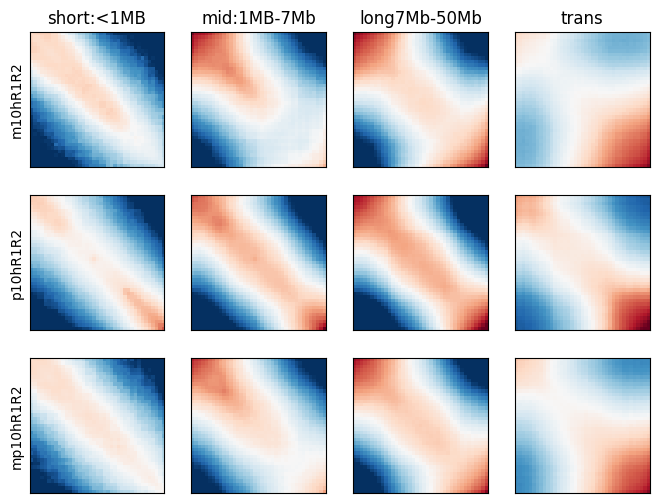

In [133]:
sub_samples =[
        "m10hR1R2",
        "p10hR1R2",
        "mp10hR1R2",
    ]

fig, axs = plt.subplots(
    nrows=len(sub_samples),
    ncols=len(distances),
    figsize=(2*len(distances),2*len(sub_samples)),
    sharex=True,
    sharey=True,
)

for ii, _sample in enumerate(sub_samples):
    for jj, (_dist_name, _dist) in enumerate(distances.items()):
        ax = axs[ii, jj]
        saddle_data = get_saddle_data(_sample, _dist_name, _dist)
        ax.imshow(saddle_data[1:,1:], **imshow_kwargs)
        ax.set_xticks([])
        ax.set_yticks([])

# annotate labels and titles ...
for jj, _dist_name in enumerate(distances):
    axs[0,jj].set_title(f"{_dist_name}")
for ii, _sample in enumerate(sub_samples):
    axs[ii,0].set_ylabel(_sample)


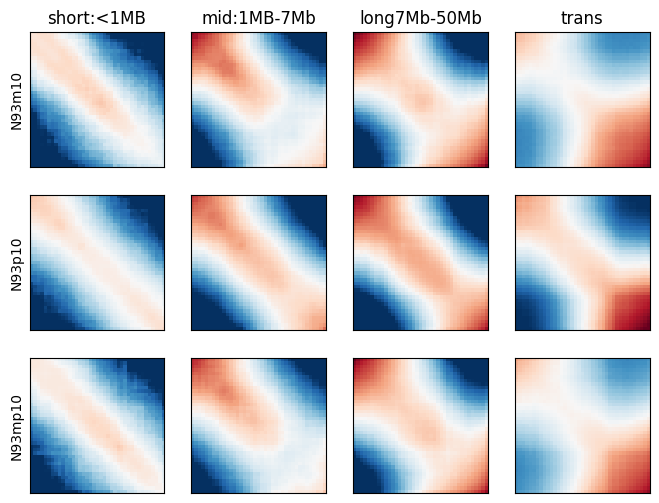

In [134]:
sub_samples = [
        "N93m10",
        "N93p10",
        "N93mp10",
    ]

fig, axs = plt.subplots(
    nrows=len(sub_samples),
    ncols=len(distances),
    figsize=(2*len(distances),2*len(sub_samples)),
    sharex=True,
    sharey=True,
)

for ii, _sample in enumerate(sub_samples):
    for jj, (_dist_name, _dist) in enumerate(distances.items()):
        ax = axs[ii, jj]
        saddle_data = get_saddle_data(_sample, _dist_name, _dist)
        ax.imshow(saddle_data[1:,1:], **imshow_kwargs)
        ax.set_xticks([])
        ax.set_yticks([])

# annotate labels and titles ...
for jj, _dist_name in enumerate(distances):
    axs[0,jj].set_title(f"{_dist_name}")
for ii, _sample in enumerate(sub_samples):
    axs[ii,0].set_ylabel(_sample)


In [470]:
# import matplotlib.pyplot as plt
import bbi
import matplotlib.lines as lines
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch, Rectangle
from mpl_toolkits.axes_grid1 import Divider, Size
from mpl_toolkits.axes_grid1.inset_locator import BboxConnector

In [516]:
telo_clrs

{'mMito': <Cooler "ranGAP1-0-Ms-R1R2.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'mTelo': <Cooler "ranGAP1-0-Telo-R2.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'mCyto': <Cooler "ranGAP1-0-Cyto-R1.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'm5hR1R2': <Cooler "ranGAP1-0-G1s-R1R2.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'm10hR1R2': <Cooler "ranGAP1-0-10hR-R1R3.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'pMito': <Cooler "ranGAP1-2-Ms-R1R2.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'pTelo': <Cooler "ranGAP1-4-Telo-R2.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'pCyto': <Cooler "ranGAP1-4-Cyto-R1.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'p5hR1R2': <Cooler "ranGAP1-7-G1s-R1R2.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'p10hR1R2': <Cooler "ranGAP1-12-10hR-R1R3.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'mp10hR1R2': <Cooler "ranGAP1-7-10hR-R1R3.hg38.mapq_30.1000.mcool::/resolutions/25000">,
 'N93m5': <Cooler "N93-0-G1s-R1R2.hg38.mapq_30.1000.m

In [519]:

Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each
n_bins = N_GROUPS

sample_m, sample_p = 'N93m5', 'N93p5'

track = align_track_with_cooler(
    telo_cis_eigs_gene[sample_m][1][["chrom","start","end","E1"]],
    telo_clrs[sample_m],
    view_df=hg38_arms,
    clr_weight_name="weight",
    mask_clr_bad_bins=True,
    drop_track_na=False,  # this adds check for chromosomes that have all missing values
)
digitized_track, binedges = digitize(
    track.iloc[:, :4],
    n_bins,
    # vrange=vrange,
    qrange=qrange,
    digitized_suffix=".d",
)
digitized_track["value"] = track["value"]
xxxm = digitized_track.groupby("value.d")["value"].mean()

track = align_track_with_cooler(
    telo_cis_eigs_gene[sample_p][1][["chrom","start","end","E1"]],
    telo_clrs[sample_p],
    view_df=hg38_arms,
    clr_weight_name="weight",
    mask_clr_bad_bins=True,
    drop_track_na=False,  # this adds check for chromosomes that have all missing values
)
digitized_track, binedges = digitize(
    track.iloc[:, :4],
    n_bins,
    # vrange=vrange,
    qrange=qrange,
    digitized_suffix=".d",
)
digitized_track["value"] = track["value"]
xxxp = digitized_track.groupby("value.d")["value"].mean()

/tmp/ipykernel_954044/945032172.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xxxm = digitized_track.groupby("value.d")["value"].mean()
/tmp/ipykernel_954044/945032172.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xxxp = digitized_track.groupby("value.d")["value"].mean()


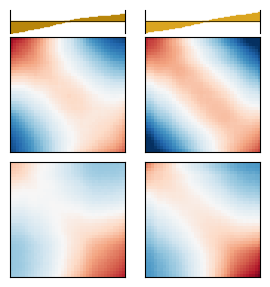

In [520]:
w, h = 6, 2.8
margin = 0.2
matw = 1.15

fig = plt.figure(
    figsize=(w, h),
    # facecolor='lightblue'
)


# The first items are for padding and the second items are for the axes, sizes are in inch.
h = [
    Size.Fixed(margin), Size.Fixed(matw),
    Size.Fixed(margin), Size.Fixed(matw),
    # Size.Fixed(margin), Size.Fixed(matw),
    # Size.Fixed(margin), Size.Fixed(matw),
]
# goes from bottom to the top ...
v = [
    Size.Fixed(0.1), Size.Fixed(matw),
    Size.Fixed(0.1), Size.Fixed(matw),
    Size.Fixed(0.2*margin), Size.Fixed(matw*0.2),
    Size.Fixed(0.2*margin), Size.Fixed(matw),
]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
axs = {}
axs["cis_ctrl"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=3))
axs["trans_ctrl"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1))
axs["cis_ctrl_ev"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=5))

axs["cis_delta"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=3, ny=3))
axs["trans_delta"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=3, ny=1))
axs["cis_delta_ev"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=3, ny=5))



########################################
for k, ax in axs.items():
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

_dist_name = "all_cis"
Cm = get_saddle_data(sample_m, _dist_name, None)
Cp = get_saddle_data(sample_p,  _dist_name, None)
axs["cis_ctrl"].imshow(Cm[1:-1,1:-1], **imshow_kwargs)
axs["cis_delta"].imshow(Cp[1:-1,1:-1], **imshow_kwargs)

_dist_name = "trans"
Cm = get_saddle_data(sample_m, _dist_name, None)
Cp = get_saddle_data(sample_p,  _dist_name, None)
axs["trans_ctrl"].imshow(Cm[1:-1,1:-1], **imshow_kwargs)
axs["trans_delta"].imshow(Cp[1:-1,1:-1], **imshow_kwargs)

# # annotate labels and titles ...
# for jj, _dist_name in enumerate(distances):
#     # m ...
#     axs[0, jj].set_title(f"m-{_dist_name}")
#     # p ...
#     axs[0, len(distances) + jj].set_title(f"p-{_dist_name}")
# for ii, _sample in enumerate(sub_samples_m):
#     axs[ii,0].set_ylabel(_sample.lstrip("m"))
#     axs[ii,0].set_yticks([])
#     axs[ii,0].set_xticks([])

data = xxxm.loc[1:38]
axs["cis_ctrl_ev"].fill_between(data.index, data, 0, color="darkgoldenrod", ec="darkgoldenrod",step="mid")
axs["cis_ctrl_ev"].set_ylim(-1.2,1.2)
axs["cis_ctrl_ev"].set_xlim(1,38.1)
axs["cis_ctrl_ev"].spines[:].set_visible(False)
axs["cis_ctrl_ev"].axhline(0,color="black",lw=0.5)
axs["cis_ctrl_ev"].spines["right"].set_visible(True)
axs["cis_ctrl_ev"].spines["left"].set_visible(True)
# ax.tick_params(bottom=False,left=True,labelbottom=False)
# # ax.set_frame_on(False)
# # plt.axis("off")
# ax.grid(color="black",lw=0.5)


data = xxxp.loc[1:38]
axs["cis_delta_ev"].fill_between(data.index, data, 0, color="goldenrod", ec="goldenrod",step="mid")
axs["cis_delta_ev"].set_ylim(-1.2,1.2)
axs["cis_delta_ev"].set_xlim(1,38.1)
axs["cis_delta_ev"].spines[:].set_visible(False)
axs["cis_delta_ev"].axhline(0,color="black",lw=0.5)
axs["cis_delta_ev"].spines["right"].set_visible(True)
axs["cis_delta_ev"].spines["left"].set_visible(True)



In [514]:
Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each
n_bins = N_GROUPS
# vrange = (-2.5,2.5)
# qrange=(Q_LO,Q_HI)

sample_m, sample_p = "m5hR1R2", "p5hR1R2"


track = align_track_with_cooler(
    telo_cis_eigs_gene[sample_m][1][["chrom","start","end","E1"]],
    telo_clrs[sample_m],
    view_df=hg38_arms,
    clr_weight_name="weight",
    mask_clr_bad_bins=True,
    drop_track_na=False,  # this adds check for chromosomes that have all missing values
)
digitized_track, binedges = digitize(
    track.iloc[:, :4],
    n_bins,
    # vrange=vrange,
    qrange=qrange,
    digitized_suffix=".d",
)
digitized_track["value"] = track["value"]
xxxm = digitized_track.groupby("value.d")["value"].mean()

track = align_track_with_cooler(
    telo_cis_eigs_gene[sample_p][1][["chrom","start","end","E1"]],
    telo_clrs[sample_p],
    view_df=hg38_arms,
    clr_weight_name="weight",
    mask_clr_bad_bins=True,
    drop_track_na=False,  # this adds check for chromosomes that have all missing values
)
digitized_track, binedges = digitize(
    track.iloc[:, :4],
    n_bins,
    # vrange=vrange,
    qrange=qrange,
    digitized_suffix=".d",
)
digitized_track["value"] = track["value"]
xxxp = digitized_track.groupby("value.d")["value"].mean()

/tmp/ipykernel_954044/968128717.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xxxm = digitized_track.groupby("value.d")["value"].mean()
/tmp/ipykernel_954044/968128717.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xxxp = digitized_track.groupby("value.d")["value"].mean()


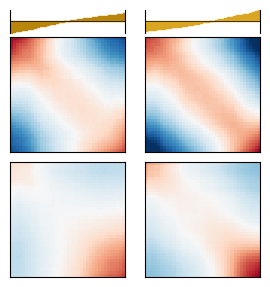

In [515]:

w, h = 6, 2.8
margin = 0.2
matw = 1.15

fig = plt.figure(
    figsize=(w, h),
)

# The first items are for padding and the second items are for the axes, sizes are in inch.
h = [
    Size.Fixed(margin), Size.Fixed(matw),
    Size.Fixed(margin), Size.Fixed(matw),
]
# goes from bottom to the top ...
v = [
    Size.Fixed(0.1), Size.Fixed(matw),
    Size.Fixed(0.1), Size.Fixed(matw),
    Size.Fixed(0.2*margin), Size.Fixed(matw*0.2),
    Size.Fixed(0.2*margin), Size.Fixed(matw),
]

divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
axs = {}
axs["cis_ctrl"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=3))
axs["trans_ctrl"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1))
axs["cis_ctrl_ev"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=5))

axs["cis_delta"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=3, ny=3))
axs["trans_delta"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=3, ny=1))
axs["cis_delta_ev"] = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=3, ny=5))

########################################
for k, ax in axs.items():
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

_dist_name = "all_cis"
Cm = get_saddle_data(sample_m, _dist_name, None)
Cp = get_saddle_data(sample_p,  _dist_name, None)
axs["cis_ctrl"].imshow(Cm[1:-1,1:-1], **imshow_kwargs)
axs["cis_delta"].imshow(Cp[1:-1,1:-1], **imshow_kwargs)

_dist_name = "trans"
Cm = get_saddle_data(sample_m, _dist_name, None)
Cp = get_saddle_data(sample_p,  _dist_name, None)
axs["trans_ctrl"].imshow(Cm[1:-1,1:-1], **imshow_kwargs)
axs["trans_delta"].imshow(Cp[1:-1,1:-1], **imshow_kwargs)


data = xxxm.loc[1:38]
axs["cis_ctrl_ev"].fill_between(data.index, data, 0, color="darkgoldenrod", ec="darkgoldenrod",step="mid")
axs["cis_ctrl_ev"].set_ylim(-1.2,1.2)
axs["cis_ctrl_ev"].set_xlim(1,38.1)
axs["cis_ctrl_ev"].spines[:].set_visible(False)
axs["cis_ctrl_ev"].axhline(0,color="black",lw=0.5)
axs["cis_ctrl_ev"].spines["right"].set_visible(True)
axs["cis_ctrl_ev"].spines["left"].set_visible(True)


data = xxxp.loc[1:38]
axs["cis_delta_ev"].fill_between(data.index, data, 0, color="goldenrod", ec="goldenrod",step="mid")
axs["cis_delta_ev"].set_ylim(-1.2,1.2)
axs["cis_delta_ev"].set_xlim(1,38.1)
axs["cis_delta_ev"].spines[:].set_visible(False)
axs["cis_delta_ev"].axhline(0,color="black",lw=0.5)
axs["cis_delta_ev"].spines["right"].set_visible(True)
axs["cis_delta_ev"].spines["left"].set_visible(True)


In [532]:
# bebe = 
imshow_kwargs["cmap"]

'RdBu_r'

In [525]:
bebe.vmin, bebe.vmax

(0.2, 3.0)

In [545]:
from matplotlib import cm
from matplotlib.colors import PowerNorm

In [560]:
# f.colorbar??

/tmp/ipykernel_954044/1072875783.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm.get_cmap(imshow_kwargs["cmap"])#(0.5)


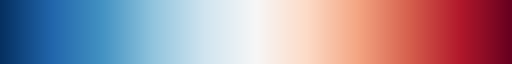

In [569]:
cm.get_cmap(imshow_kwargs["cmap"])#(0.5)

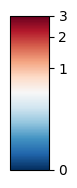

In [570]:

f = plt.figure(figsize=(0.5,2))
cax = f.add_subplot()


plt.colorbar(
    cm.ScalarMappable(norm=PowerNorm(1/3., vmin=imshow_kwargs["norm"].vmin, vmax=imshow_kwargs["norm"].vmax), cmap=imshow_kwargs["cmap"]),
    cax=cax,
)
# f.colorbar(
#     cm.ScalarMappable(norm=imshow_kwargs["norm"], cmap=imshow_kwargs["cmap"]),
#     cax=cax,
# )
# # cax.set_yticks([imshow_kwargs["norm"].vmin, imshow_kwargs["norm"].midpoint, imshow_kwargs["norm"].vmax])
# # cax.set_yticklabels([imshow_kwargs["norm"].vmin, imshow_kwargs["norm"].midpoint, imshow_kwargs["norm"].vmax])

In [554]:
imshow_kwargs["norm"](1)

masked_array(data=0.5,
             mask=False,
       fill_value=1e+20)

In [543]:
cm.ScalarMappable??

Init signature: cm.ScalarMappable(norm=None, cmap=None)
Source:        
class ScalarMappable:
    """
    A mixin class to map scalar data to RGBA.

    The ScalarMappable applies data normalization before returning RGBA colors
    from the given colormap.
    """

    def __init__(self, norm=None, cmap=None):
        """
        Parameters
        ----------
        norm : `.Normalize` (or subclass thereof) or str or None
            The normalizing object which scales data, typically into the
            interval ``[0, 1]``.
            If a `str`, a `.Normalize` subclass is dynamically generated based
            on the scale with the corresponding name.
            If *None*, *norm* defaults to a *colors.Normalize* object which
            initializes its scaling based on the first data processed.
        cmap : str or `~matplotlib.colors.Colormap`
            The colormap used to map normalized data values to RGBA colors.
        """
        self._A = None
        self._norm = Non

In [588]:

# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        vmin, midpoint, vmax = self.vmin, self.midpoint, self.vmax
        x, y = [np.log(vmin), np.log(midpoint), np.log(vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        # t_vmin, t_midpoint, t_vmax = np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)
        vmin, midpoint, vmax = self.vmin, self.midpoint, self.vmax

        x, y = [0, 0.5, 1], [np.log(vmin), np.log(midpoint), np.log(vmax)]
        # # return np.ma.masked_array(np.interp(np.log(value), x, y))
        # if np.iterable(value):
        #     val = np.ma.asarray(value)
        #     return np.ma.power(val, 1. / gamma) * (vmax - vmin) + vmin
        # else:
        # return pow(value, 1. / gamma) * (vmax - vmin) + vmin
        return np.exp(np.interp(value, x, y))



In [589]:

vmin, midpoint, vmax = 0.2,1,3
x,y = [np.log(vmin), np.log(midpoint), np.log(vmax)], [0, 0.5, 1]
np.interp(np.log(0.2), x, y)

0.0

In [590]:

vmin, midpoint, vmax = 0.2,1,3
x,y = [np.log(vmin), np.log(midpoint), np.log(vmax)], [0, 0.5, 1]
np.interp(np.log(0.2), x, y)

0.0

[Text(1, 0.2, '0.2'), Text(1, 1.0, '1'), Text(1, 3.0, '3.0')]

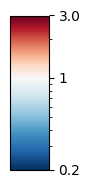

In [593]:

f = plt.figure(figsize=(0.5,2))
cax = f.add_subplot()


# plt.colorbar(
#     cm.ScalarMappable(norm=PowerNorm(1/3., vmin=imshow_kwargs["norm"].vmin, vmax=imshow_kwargs["norm"].vmax), cmap=imshow_kwargs["cmap"]),
#     cax=cax,
# )


_ppp = MidPointLogNorm(vmin=1/5,vmax=3,midpoint=1)
f.colorbar(
    cm.ScalarMappable(norm=_ppp, cmap="RdBu_r"),
    cax=cax,
)
cax.set_yticks([imshow_kwargs["norm"].vmin, imshow_kwargs["norm"].midpoint, imshow_kwargs["norm"].vmax])
cax.set_yticklabels([imshow_kwargs["norm"].vmin, imshow_kwargs["norm"].midpoint, imshow_kwargs["norm"].vmax])

In [536]:
imshow_kwargs["norm"].vmin

0.2

In [ ]:
imshow_kwargs["norm"].cen